In [1]:
import numpy as np
import quaternion
import plotly.graph_objs as go
import pandas as pd
import torch
import copy
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16, 9)

def vector_plot(tvects,is_vect=True,orig=[0,0,0]):
    """Plot vectors using plotly"""

    if is_vect:
        if not hasattr(orig[0],"__iter__"):
            coords = [[orig,np.sum([orig,v],axis=0)] for v in tvects]
        else:
            coords = [[o,np.sum([o,v],axis=0)] for o,v in zip(orig,tvects)]
    else:
        coords = tvects

    data = []
    for i,c in enumerate(coords):
        X1, Y1, Z1 = zip(c[0])
        X2, Y2, Z2 = zip(c[1])
        vector = go.Scatter3d(x = [X1[0],X2[0]],
                              y = [Y1[0],Y2[0]],
                              z = [Z1[0],Z2[0]],
                              marker = dict(size = [0,5],
                                            color = ['blue'],
                                            line=dict(width=5,
                                                      color='DarkSlateGrey')),
                              name = 'Vector'+str(i+1))
        data.append(vector)

    layout = go.Layout(
             margin = dict(l = 4,
                           r = 4,
                           b = 4,
                           t = 4)
                  )
    fig = go.Figure(data=data,layout=layout)
    fig.show()

c:\Users\jakub\anaconda3\envs\neuralode\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Shows how to find a quaternion rotation that rotates a vector to another

v_i = np.array([1.0, 0.0, 0.0])
v_f = np.array([0.0, 0.0, 1.0])

abc = np.cross(v_i, v_f)

w = np.sqrt((np.linalg.norm(v_i) ** 2) * (np.linalg.norm(v_f) ** 2)) + np.dot(v_i, v_f)

q = quaternion.quaternion(w, *abc).normalized()
print(q)

v_rotated = q * quaternion.from_vector_part(v_i) * q.conj()
v_rotated = np.array(quaternion.as_vector_part(v_rotated))

vector_plot([v_i, v_rotated])

quaternion(0.707106781186547, 0, -0.707106781186547, 0)


In [3]:
q = quaternion.quaternion(1, 2, 2.5, 0.25).normalized()
q = quaternion.as_float_array(q).reshape(-1, 1)

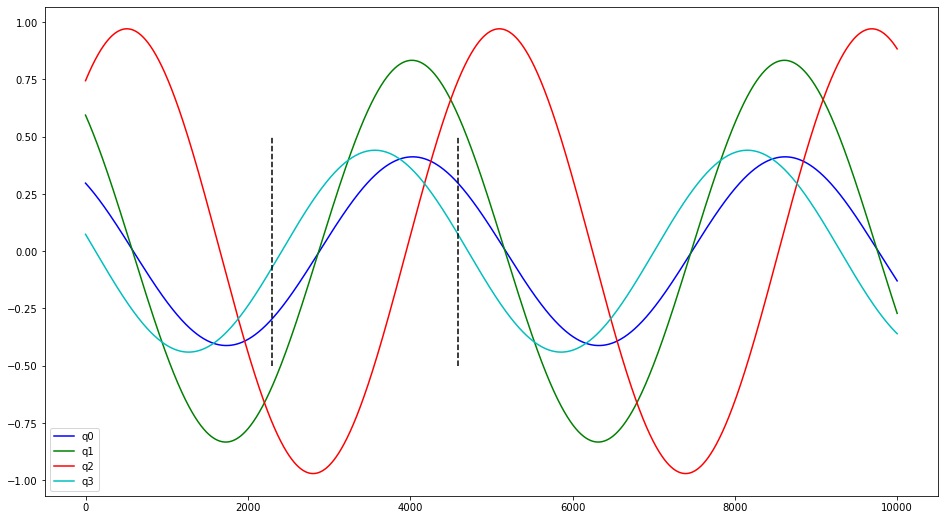

In [4]:
# No torque, hence no change in angular momentum and thus only a constant change/evolution in the quaternion
J = np.identity(3)
J_inv = np.linalg.inv(J)
l_i = np.array([0.1, 0.05, -0.25]).reshape(-1, 1)
# q = np.array([0.707106781186547, 0, -0.707106781186547, 0]).reshape(-1, 1)
period = 2 * np.pi / np.linalg.norm((J_inv @ l_i))
dt = 0.01
timesteps = 10000
time = timesteps / dt


def G(q):
    return np.array([[-q[1], q[0], q[3], -q[2]], [-q[2], -q[3], q[0], q[1]], [-q[3], q[2], -q[1], q[0]]]).squeeze()

def diffquat(q, l):
    return 0.5 * G(q).T @ J_inv @ l

def velverlet_step(q, l, dt):
    q_new = q + dt * diffquat(q, l)
    q_new = q_new / np.linalg.norm(q_new)
    return q_new

traj = []

assert q.shape == (4, 1), 'q must be a 4x1 array'

for i in range(timesteps):
    q = velverlet_step(q, l_i, dt)
    traj.append(q.squeeze())
traj = np.stack(traj)

plt.plot(traj[:, 0], 'b', label='q0')
plt.plot(traj[:, 1], 'g', label='q1')
plt.plot(traj[:, 2], 'r', label='q2')
plt.plot(traj[:, 3], 'c', label='q3')
plt.plot([period / dt, period / dt],[-.5, .5], 'k--')
plt.plot([period / dt * 2, period / dt * 2],[-.5, .5], 'k--')
plt.legend()
plt.show()


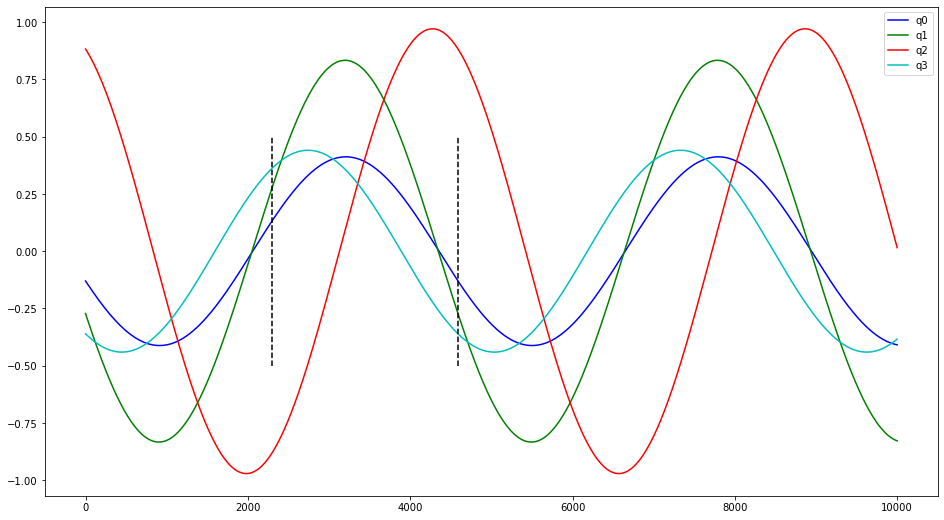

In [5]:
# Pendulum
J = np.identity(3)
J_inv = np.linalg.inv(J)
l_i = np.array([0.1, 0.05, -0.25]).reshape(-1, 1)
# q = np.array([0.707106781186547, 0, -0.707106781186547, 0]).reshape(-1, 1)
period = 2 * np.pi / np.linalg.norm((J_inv @ l_i))
dt = 0.01
timesteps = 10000
time = timesteps / dt


def G(q):
    return np.array([[-q[1], q[0], q[3], -q[2]], [-q[2], -q[3], q[0], q[1]], [-q[3], q[2], -q[1], q[0]]]).squeeze()

def diffquat(q, l):
    return 0.5 * G(q).T @ J_inv @ l

def velverlet_step(q, l, dt):
    q_new = q + dt * diffquat(q, l)
    q_new = q_new / np.linalg.norm(q_new)
    return q_new

traj = []

assert q.shape == (4, 1), 'q must be a 4x1 array'

for i in range(timesteps):
    q = velverlet_step(q, l_i, dt)
    traj.append(q.squeeze())
traj = np.stack(traj)

plt.plot(traj[:, 0], 'b', label='q0')
plt.plot(traj[:, 1], 'g', label='q1')
plt.plot(traj[:, 2], 'r', label='q2')
plt.plot(traj[:, 3], 'c', label='q3')
plt.plot([period / dt, period / dt],[-.5, .5], 'k--')
plt.plot([period / dt * 2, period / dt * 2],[-.5, .5], 'k--')
plt.legend()
plt.show()


### Using Data

In [6]:
from analysis.reader import Reader

def get_data(file_name):
    # train_split = 0.9
    # test_split = 1 - train_split
    df = pd.read_csv(file_name+'-reduced_traj.csv')
    # HACK: do this based on the column names, not explicitly
    com = ['c_com_1[1]', 'c_com_1[2]', 'c_com_1[3]'] #, 'c_com_2[1]', 'c_com_2[2]', 'c_com_2[3]']
    q = ['c_q_1[1]', 'c_q_1[2]', 'c_q_1[3]', 'c_q_1[4]'] #, 'c_q_2[1]', 'c_q_2[2]', 'c_q_2[3]', 'c_q_2[4]']
    vel = ['c_vel_1[1]', 'c_vel_1[2]', 'c_vel_1[3]'] #, 'c_vel_2[1]', 'c_vel_2[2]', 'c_vel_2[3]'] 
    av = ['c_av_1[1]', 'c_av_1[2]', 'c_av_1[3]'] # , 'c_av_2[1]', 'c_av_2[2]', 'c_av_2[3]']
    am = ['c_am_1[1]', 'c_am_1[2]', 'c_am_1[3]'] #, 'c_am_2[1]', 'c_am_2[2]', 'c_am_2[3]']
    inertia = ['c_i_1[1]', 'c_i_1[2]', 'c_i_1[3]'] #, 'c_i_2[1]', 'c_i_2[2]', 'c_i_2[3]']
    
    centre_of_masses = df.loc[:, ['timestep', *com]]
    quaternions = df.loc[:, ['timestep', *q]]
    velocities = df.loc[:, ['timestep', *vel]]
    ang_velocities = df.loc[:, ['timestep', *av]]
    ang_momenta = df.loc[:, ['timestep', *am]]
    # inertia = df.loc[0, ['timestep', *inertia]]
    inertia = df.loc[:, ['timestep', *inertia]]
    # TODO: use DataLoaders?
    
    # trajs = np.load('data/trajectories/diatomic_spring_narrow.npy')
    # split_index = int(trajs.shape[0] * train_split)

    # np.random.shuffle(trajs)
    # training_trajs = torch.Tensor(trajs[:split_index, :, :]).to(device)
    # testing_trajs = torch.Tensor(trajs[split_index:, :, :]).to(device)
    
    return centre_of_masses, quaternions, velocities, ang_velocities, ang_momenta, inertia

def process_data(centre_of_masses, quaternions, velocities, ang_momenta, inertia):
    # TODO: swap -1 and nparticles in view to avoid swapping axes later on
    # HACK: send a single trajectory
    ntraj = 1

    # HACK: pair potential
    nparticles = 1
    vel_dim = 3
    angvel_dim = 3
    com_dim = 3
    quat_dim = 4

    # Get centre of masses
    com1 = centre_of_masses.loc[:, ['c_com_1[1]', 'c_com_1[2]', 'c_com_1[3]']].to_numpy()
    # com2 = centre_of_masses.loc[:, ['c_com_2[1]', 'c_com_2[2]', 'c_com_2[3]']].to_numpy()
    # separation = np.linalg.norm(com1-com2, axis=1).reshape(-1, 1)
    coms = torch.from_numpy(np.hstack((com1))).to(device).view(ntraj, -1, nparticles, com_dim)
    
    # Get quaternion rotations (swap axes to put real part first)
    # quat1 = quaternions.loc[:, ['c_q_1[4]', 'c_q_1[1]', 'c_q_1[2]', 'c_q_1[3]']].to_numpy()
    # quat2 = quaternions.loc[:, ['c_q_2[4]', 'c_q_2[1]', 'c_q_2[2]', 'c_q_2[3]']].to_numpy()
    quat1 = quaternions.loc[:, ['c_q_1[4]', 'c_q_1[1]', 'c_q_1[2]', 'c_q_1[3]']].to_numpy()
    # quat2 = quaternions.loc[:, ['c_q_2[4]', 'c_q_2[1]', 'c_q_2[2]', 'c_q_2[3]']].to_numpy()
    quats = torch.from_numpy(np.hstack((quat1))).to(device).view(ntraj, -1, nparticles, quat_dim)
    
    # Get translation velocities
    vel1 = velocities.loc[:, ['c_vel_1[1]', 'c_vel_1[2]', 'c_vel_1[3]']].to_numpy()
    # vel2 = velocities.loc[:, ['c_vel_2[1]', 'c_vel_2[2]', 'c_vel_2[3]']].to_numpy() 
    # hexagon_mass = 7.0
    # mom = torch.from_numpy(np.hstack((vel1 * hexagon_mass, vel2 * hexagon_mass))).to(device).view(ntraj, -1, nparticles, vel_dim)
    vel = torch.from_numpy(np.hstack((vel1))).to(device).view(ntraj, -1, nparticles, vel_dim)

    # Get angular velocities
    ang_mom = torch.from_numpy(ang_momenta.iloc[:, 1:].to_numpy()).to(device).view(ntraj, -1, nparticles, angvel_dim)
    ang_vel = ang_mom / inertia.view(ntraj, -1, nparticles, angvel_dim)
    
    return (vel, ang_vel, coms, quats)

def process_inertia(inertia):
    assert np.all(inertia.std().iloc[1:].to_numpy() == 0), 'inertia is not constant'
    inertia = inertia.iloc[0, 1:].to_numpy().reshape(1, 3)
    return torch.from_numpy(inertia).to(device)

# prefix = 'hexagons/trajectories/dump_2503/cutoff-2.5/'
# file_name = prefix+'NVE-temp-2.25_K-0.018140589569161_r-0_s-5'

# prefix = 'hexagons/trajectories/max_log_freq/'
# file_name = prefix+'NVE-temp-2.25_K-0.018140589569161_r-0_s-5'

prefix = 'hexagons/trajectories/single/'
file_name = prefix+'NVE-temp-2.25_K-0.018140589569161_r-0_s-5'


device = 'cpu'

reader = Reader(file_name)
# log_labels, log_lines = reader.read_simulation_log()
traj_labels, traj_lines = reader.read_reduced_traj(save=True)
# orig_labels, orig_lines = reader.read_original_traj(save=True)


centre_of_masses, quaternions, velocities, ang_velocities, ang_momenta, inertia = get_data(file_name)
inertia = process_inertia(inertia)
trajectory = process_data(centre_of_masses, quaternions, velocities, ang_momenta, inertia)
print(trajectory[1])

Found timestep: 1e-05, n of run steps: 4000000, and dump log freq: 1000
tensor([[[[ 0.6275,  0.3293, -0.9348]],

         [[ 0.6275,  0.3293, -0.9348]],

         [[ 0.6275,  0.3293, -0.9348]],

         ...,

         [[ 0.6275,  0.3293, -0.9348]],

         [[ 0.6275,  0.3293, -0.9348]],

         [[ 0.6275,  0.3293, -0.9348]]]], dtype=torch.float64)


### Comparison: Angular Velocity (System) vs. Angular Momentum (Body)

In [13]:
prefix = 'hexagons/trajectories/periodic/'
file_name = prefix+'NVE-temp-2.25_K-0.018140589569161_r-0_s-5'
# prefix = 'hexagons/trajectories/dump_2503/cutoff-2.5/'
# file_name = prefix+'NVE-temp-2.25_K-0.018140589569161_r-0_s-5'

device = 'cpu'
reader = Reader(file_name)
traj_labels, traj_lines = reader.read_reduced_traj(save=True)

centre_of_masses, quaternions, velocities, ang_velocities, ang_momenta, inertia = get_data(file_name)
inertia = process_inertia(inertia)
ang_velocities = ang_velocities.to_numpy()[:, 1:]
ang_momenta = ang_momenta.to_numpy()[:, 1:]

plt.plot(ang_velocities, 'b', label='ang_velocities')
plt.plot(ang_momenta, 'g', label='ang_momenta')
plt.legend()
plt.show()

# kinetic energy = 0.5 * I * w^2
Ek_from_vel = np.sum(0.5 * inertia.numpy() * (ang_velocities**2), axis=1)
Ek_from_mom = np.sum(0.5 * (ang_momenta**2) / inertia.numpy(), axis=1)

plt.plot(Ek_from_vel, 'b', label='Ek_from_vel')
plt.plot(Ek_from_mom, 'g', label='Ek_from_mom')

plt.legend()
plt.savefig('hello.png')
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'hexagons/trajectories/periodic/NVE-temp-2.25_K-0.018140589569161_r-0_s-5-input.log'

Found timestep: 1e-05, n of run steps: 100000000, and dump log freq: 10000
[[-3.62208  -3.15989  -0.665328]
 [-3.66883  -3.00164  -0.507559]
 [-3.72169  -2.87876  -0.424877]
 ...
 [ 4.81729  -1.91647  -4.87731 ]
 [ 4.81729  -1.91647  -4.87731 ]
 [ 4.81729  -1.91647  -4.87731 ]]
[[3. 3. 6.]]
[[-1.20736    -1.05329667 -0.110888  ]
 [-1.22294333 -1.00054667 -0.08459317]
 [-1.24056333 -0.95958667 -0.07081283]
 ...
 [ 1.60576333 -0.63882333 -0.812885  ]
 [ 1.60576333 -0.63882333 -0.812885  ]
 [ 1.60576333 -0.63882333 -0.812885  ]]


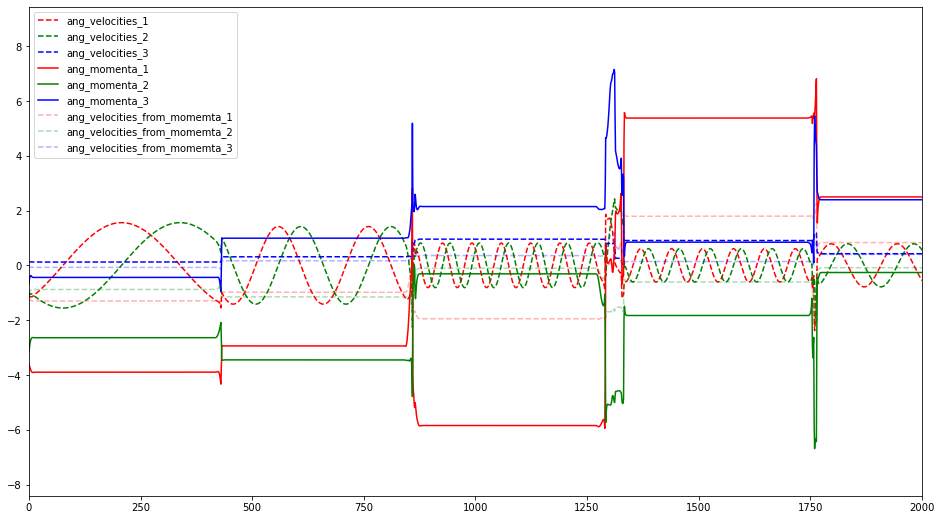

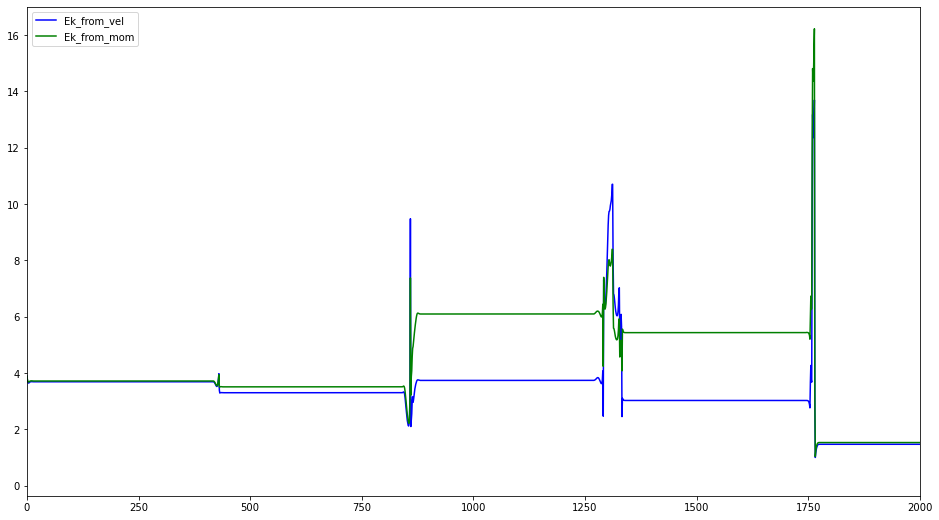

In [128]:
# prefix = 'hexagons/trajectories/periodic/'
# file_name = prefix+'NVE-temp-2.25_K-0.018140589569161_r-0_s-5'
prefix = 'hexagons/trajectories/dump_2503/cutoff-2.5/'
file_name = prefix+'NVE-temp-2.25_K-0.018140589569161_r-0_s-5'
# rotate angular velocities
device = 'cpu'
reader = Reader(file_name)
traj_labels, traj_lines = reader.read_reduced_traj(save=True)

centre_of_masses, quaternions, velocities, ang_velocities, ang_momenta, inertia = get_data(file_name)
inertia = process_inertia(inertia)
quaternions = quaternions.loc[:, ['c_q_1[4]', 'c_q_1[1]', 'c_q_1[2]', 'c_q_1[3]']].to_numpy()
ang_velocities = ang_velocities.to_numpy()[:, 1:]
ang_momenta = ang_momenta.to_numpy()[:, 1:]

# system coords to body coords
ang_velocities = quaternion.from_vector_part(ang_velocities)
quaternions = quaternion.from_float_array(quaternions)
ang_velocities = quaternions.conj() * ang_velocities * quaternions
ang_velocities = quaternion.as_vector_part(ang_velocities)
quaternions = quaternion.as_float_array(quaternions)

plt.plot(ang_velocities[:, 0], 'r--', label='ang_velocities_1')
plt.plot(ang_velocities[:, 1], 'g--', label='ang_velocities_2')
plt.plot(ang_velocities[:, 2], 'b--', label='ang_velocities_3')

plt.plot(ang_momenta[:, 0], 'r', label='ang_momenta_1')
plt.plot(ang_momenta[:, 1], 'g', label='ang_momenta_2')
plt.plot(ang_momenta[:, 2], 'b', label='ang_momenta_3')

print(ang_momenta)
print(inertia.numpy())
ang_velocities_from_momemta = ang_momenta / inertia.numpy()
print(ang_velocities_from_momemta)

# plt.plot(quaternions, 'k--', alpha=0.3, label='quaternions')

plt.plot(ang_velocities_from_momemta[:, 0], 'r--', alpha=0.3, label='ang_velocities_from_momemta_1')
plt.plot(ang_velocities_from_momemta[:, 1], 'g--', alpha=0.3, label='ang_velocities_from_momemta_2')
plt.plot(ang_velocities_from_momemta[:, 2], 'b--', alpha=0.3, label='ang_velocities_from_momemta_3')
plt.xlim(0, 2000)
plt.legend()
plt.savefig('vel_mom.png')
plt.show()

# kinetic energy = 0.5 * I * w^2
Ek_from_vel = np.sum(0.5 * inertia.numpy() * (ang_velocities**2), axis=1)
Ek_from_mom = np.sum(0.5 * (ang_momenta**2) / inertia.numpy(), axis=1)

plt.plot(Ek_from_vel, 'b', label='Ek_from_vel')
plt.plot(Ek_from_mom, 'g', label='Ek_from_mom')

plt.legend()
plt.xlim(0, 2000)
plt.savefig('energies.png')
plt.show()

#### Relate to translational kinetic energy

Found timestep: 1e-05, n of run steps: 100000000, and dump log freq: 10000
(10001,)


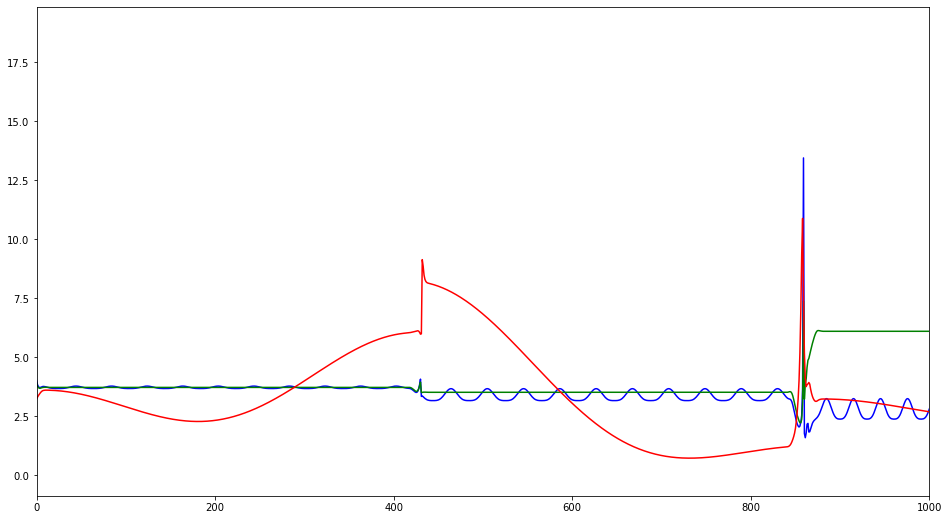

In [79]:
prefix = 'hexagons/trajectories/dump_2503/cutoff-2.5/'
file_name = prefix+'NVE-temp-2.25_K-0.018140589569161_r-0_s-5'
device = 'cpu'
reader = Reader(file_name)
traj_labels, traj_lines = reader.read_reduced_traj(save=True)

centre_of_masses, quaternions, velocities, ang_velocities, ang_momenta, inertia = get_data(file_name)
inertia = process_inertia(inertia)
ang_velocities = ang_velocities.to_numpy()[:, 1:]
ang_momenta = ang_momenta.to_numpy()[:, 1:]
velocities = velocities.to_numpy()[:, 1:]


# kinetic energies (0.5 * m * v^2 and 0.5 * I * w^2)
Ek_from_vel = np.sum(0.5 * inertia.numpy() * (ang_velocities**2), axis=1)
Ek_from_mom = np.sum(0.5 * (ang_momenta**2) / inertia.numpy(), axis=1)
Ek_translation = np.sum(0.5 * 7.0 * (velocities**2), axis=1)
print(Ek_translation.shape)

plt.plot(Ek_from_vel, 'b', label='Ek_from_vel')
plt.plot(Ek_from_mom, 'g', label='Ek_from_mom')
plt.plot(Ek_translation, 'r', label='Ek_translation')
plt.xlim(0, 1000)
# plt.ylim(3, 6)
# plt.legend()
# plt.savefig('hello.png')
plt.show()

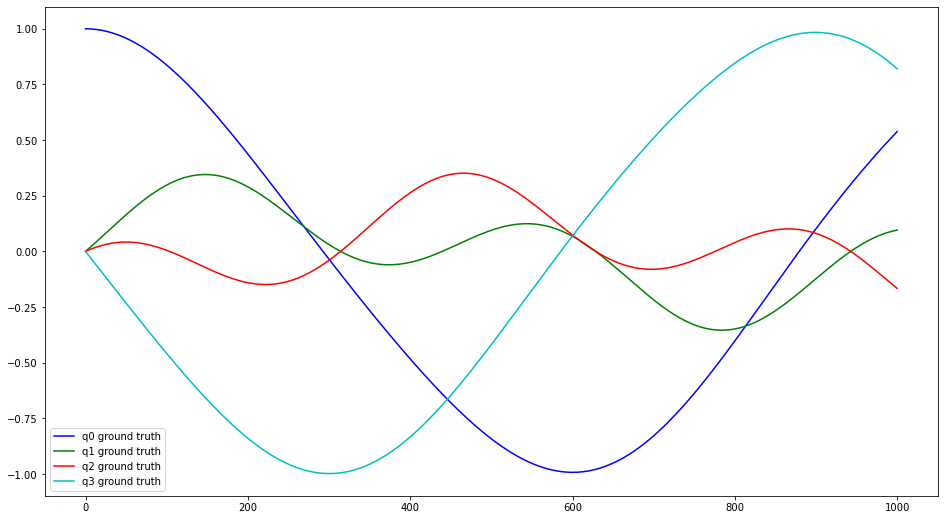

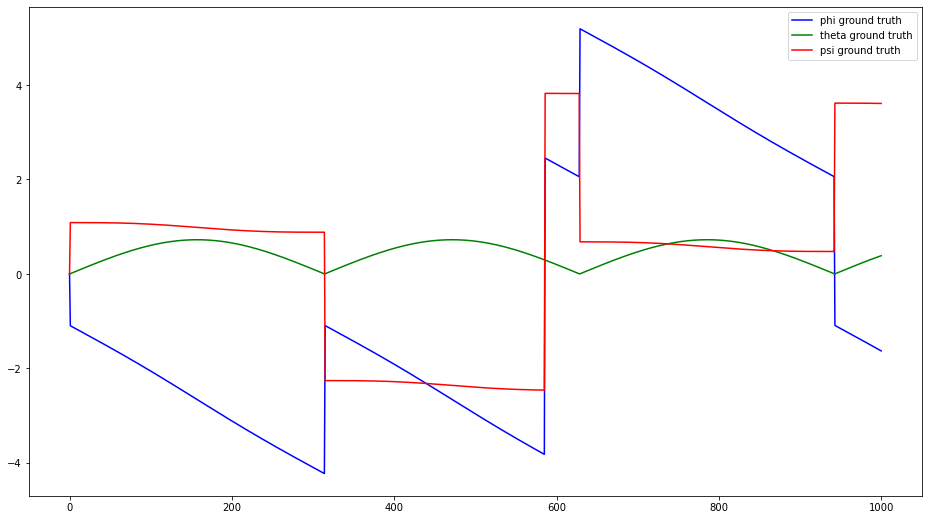

In [12]:
quat = trajectory[3][0, :, 0, :]

plt.plot(quat[:, 0], 'b', label='q0 ground truth')
plt.plot(quat[:, 1], 'g', label='q1 ground truth')
plt.plot(quat[:, 2], 'r', label='q2 ground truth')
plt.plot(quat[:, 3], 'c', label='q3 ground truth')
plt.legend()
plt.savefig('1.png')
plt.show()

quat = quaternion.from_float_array(quat)
eul = quaternion.as_euler_angles(quat)
plt.plot(eul[:, 0], 'b', label='phi ground truth')
plt.plot(eul[:, 1], 'g', label='theta ground truth')
plt.plot(eul[:, 2], 'r', label='psi ground truth')
plt.legend()
plt.savefig('2.png')
plt.show()

In [13]:
eul = quaternion.as_euler_angles(quat)

### Manually Rotated moment of inertia matrix

Found timestep: 1e-05, n of run steps: 4000000, and dump log freq: 1000


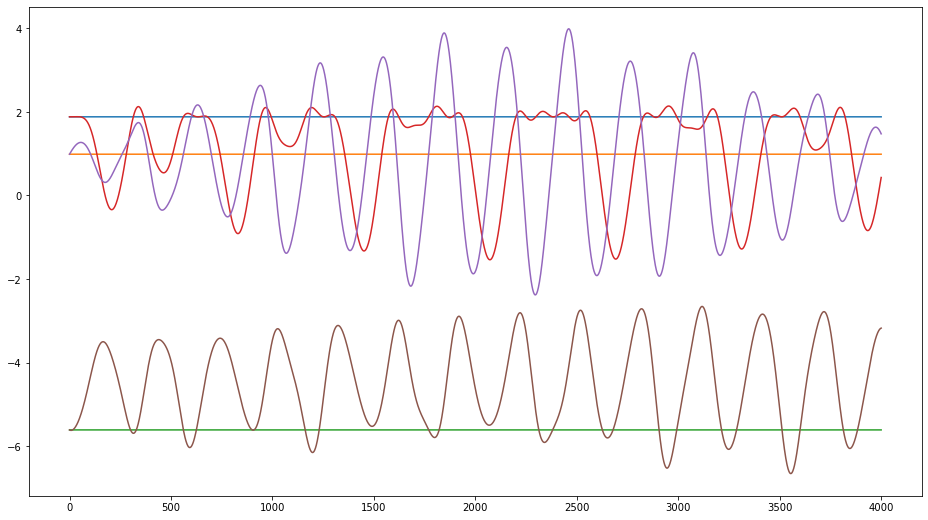

In [6]:
prefix = 'hexagons/trajectories/single/'
file_name = prefix+'NVE-temp-2.25_K-0.018140589569161_r-0_s-5'
device = 'cpu'
reader = Reader(file_name)
traj_labels, traj_lines = reader.read_reduced_traj(save=True)

centre_of_masses, quaternions, velocities, ang_velocities, ang_momenta, inertia = get_data(file_name)
inertia = process_inertia(inertia)
ang_velocities = ang_velocities.to_numpy()[:, 1:]
ang_momenta = ang_momenta.to_numpy()[:, 1:]
velocities = velocities.to_numpy()[:, 1:]
quat = quaternions.to_numpy()[:, 1:]
quat = quaternion.from_float_array(quat)

J = np.identity(3) * inertia.numpy()

R = quaternion.as_rotation_matrix(quat)
R_inv = R.transpose(0, 2, 1)
J_new = np.matmul(np.matmul(R, J), R_inv)

plt.plot(ang_momenta)

ang_mom_from_vel = np.matmul(ang_velocities.reshape(-1, 1, 3), J_new)

plt.plot(ang_mom_from_vel.reshape(-1, 3))
plt.show()

### INVESTIGATING ANGULAR VELOCITY VS MOMENTUM FROM LAMMPS

Found timestep: 1e-05, n of run steps: 4000000, and dump log freq: 1000


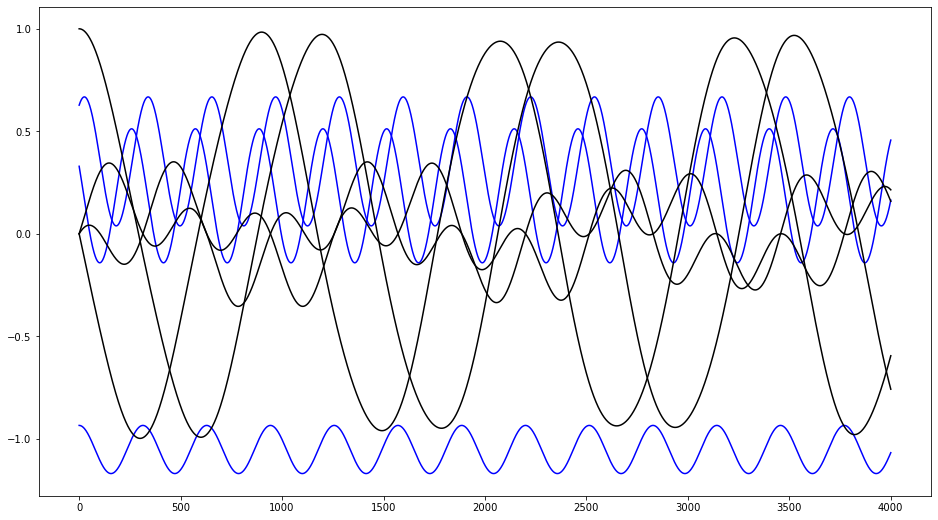

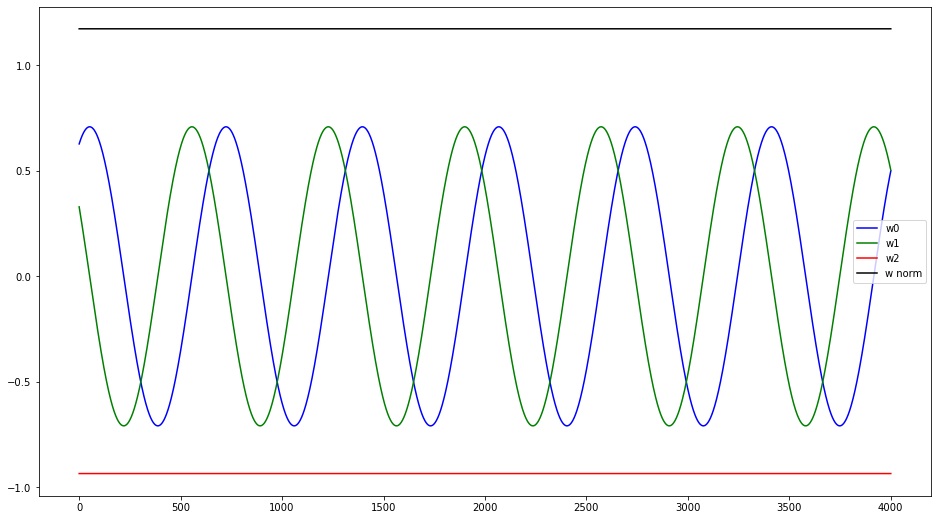

In [62]:
prefix = 'hexagons/trajectories/periodic/'
file_name = prefix+'NVE-temp-2.25_K-0.018140589569161_r-0_s-5'
device = 'cpu'
reader = Reader(file_name)
traj_labels, traj_lines = reader.read_reduced_traj(save=True)

centre_of_masses, quaternions, velocities, ang_velocities, ang_momenta, inertia = get_data(file_name)
inertia = process_inertia(inertia)
trajectory = process_data(centre_of_masses, quaternions, velocities, ang_momenta, inertia)

initial_timestep = 0
quat = trajectory[3][0, :, 0, :]

angvel = ang_velocities.to_numpy()
angvel = angvel[:, 1:]

# period of the angular veloicty is much shorter than that of the quaternion evolution

plt.plot(angvel, 'b')
plt.plot(quat, 'k')
# plt.xlim(0, 1000)
plt.show()

angvel = quaternion.from_vector_part(angvel)
quat = quaternion.from_float_array(quat)
# w_body = q conj * w_system * q
angvel = quat.conj() * angvel * quat
angvel = quaternion.as_vector_part(angvel)

plt.plot(angvel[:, 0], 'b', label='w0')
plt.plot(angvel[:, 1], 'g', label='w1')
plt.plot(angvel[:, 2], 'r', label='w2')
plt.plot(np.linalg.norm(angvel, axis=1), 'k', label='w norm')
plt.legend()
# plt.xlim(0, 1000)
plt.savefig('hello.png')
plt.show()


In [134]:
prefix = 'hexagons/trajectories/periodic/'
file_name = prefix+'NVE-temp-2.25_K-0.018140589569161_r-0_s-5'


device = 'cpu'

reader = Reader(file_name)
# log_labels, log_lines = reader.read_simulation_log()
traj_labels, traj_lines = reader.read_reduced_traj(save=True)
# orig_labels, orig_lines = reader.read_original_traj(save=True)


centre_of_masses, quaternions, velocities, ang_velocities, ang_momenta, inertia = get_data(file_name)
inertia = process_inertia(inertia)
trajectory = process_data(centre_of_masses, quaternions, velocities, ang_momenta, inertia)

Found timestep: 1e-05, n of run steps: 1000000, and dump log freq: 10000


### Working Example of Evolution with System Angular Velocity

W_SYSTEM
0
100


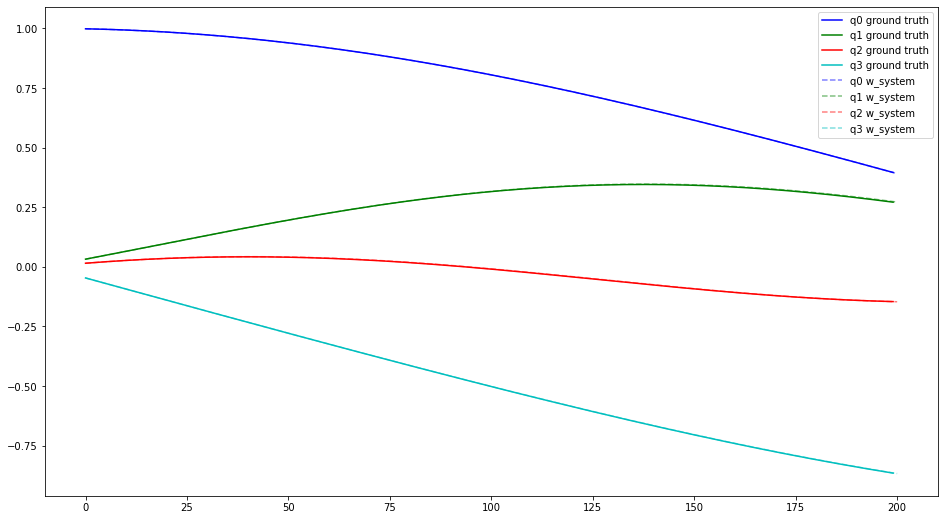

In [43]:
# Trying to use angular velocity in space-fixed coordinates to evolve the system
initial_timestep = 10
angvel = ang_velocities.to_numpy()[:, 1:]
quat = trajectory[3][0, :, 0, :]

initial_quat = quat[initial_timestep, :].clone()
J = np.identity(3) #* inertia[0].numpy()
J_inv = np.linalg.inv(J)
q_i = initial_quat.numpy()
log_freq = reader.log_frequency
time_step = reader.timestep
dt = time_step * log_freq
timesteps = 200

def vecquat(a, b):
    c = np.zeros(4)
    c[0] = -a[0] * b[1] - a[1] * b[2] - a[2] * b[3]
    c[1] = b[0] * a[0] + a[1] * b[3] - a[2] * b[2]
    c[2] = b[0] * a[1] + a[2] * b[1] - a[0] * b[3]
    c[3] = b[0] * a[2] + a[0] * b[2] - a[1] * b[1]
    return c
    
def vecquat_multiply(a, b):
    a = quaternion.from_vector_part(a)
    b = quaternion.from_float_array(b)
    c = a * b
    return quaternion.as_float_array(c)

def vecquat_G(w, q):
    # compared to the Shivarama paper, our G is defined to be an operator that acts on system angular velocity
    def G(q):
        return np.array([[-q[1], q[0], -q[3], q[2]], [-q[2], q[3], q[0], -q[1]], [-q[3], -q[2], q[1], q[0]]]).squeeze()
    
    return G(q).T @ w

print('W_SYSTEM') 


def velverlet_step(q, w, dt):
    # dqdt = 0.5 * w_system * q
    q_new = q + 0.5 * dt * vecquat_multiply(w, q)
    q_new = q_new / np.linalg.norm(q_new)
    return q_new

q = q_i
traj = [q.squeeze()]

assert len(q) == 4, 'q must have 4 coords'

for i in range(timesteps):
    q = velverlet_step(q, angvel[initial_timestep+i, :], dt)
    traj.append(q.squeeze())

    if i % 100 == 0:
        print(i)

traj = np.stack(traj)
plt.plot(quat[initial_timestep:initial_timestep+timesteps, 0], 'b', label='q0 ground truth')
plt.plot(quat[initial_timestep:initial_timestep+timesteps, 1], 'g', label='q1 ground truth')
plt.plot(quat[initial_timestep:initial_timestep+timesteps, 2], 'r', label='q2 ground truth')
plt.plot(quat[initial_timestep:initial_timestep+timesteps, 3], 'c', label='q3 ground truth')

plt.plot(traj[:, 0], 'b--', alpha=0.5, label='q0 w_system')
plt.plot(traj[:, 1], 'g--', alpha=0.5, label='q1 w_system')
plt.plot(traj[:, 2], 'r--', alpha=0.5, label='q2 w_system')
plt.plot(traj[:, 3], 'c--', alpha=0.5, label='q3 w_system')

plt.legend()
plt.savefig('hexagon_quat_traj.png')
plt.show()

### angular mmentum evolution

Found timestep: 1e-05, n of run steps: 4000000, and dump log freq: 1000
W_SYSTEM
0
100
200
300
400


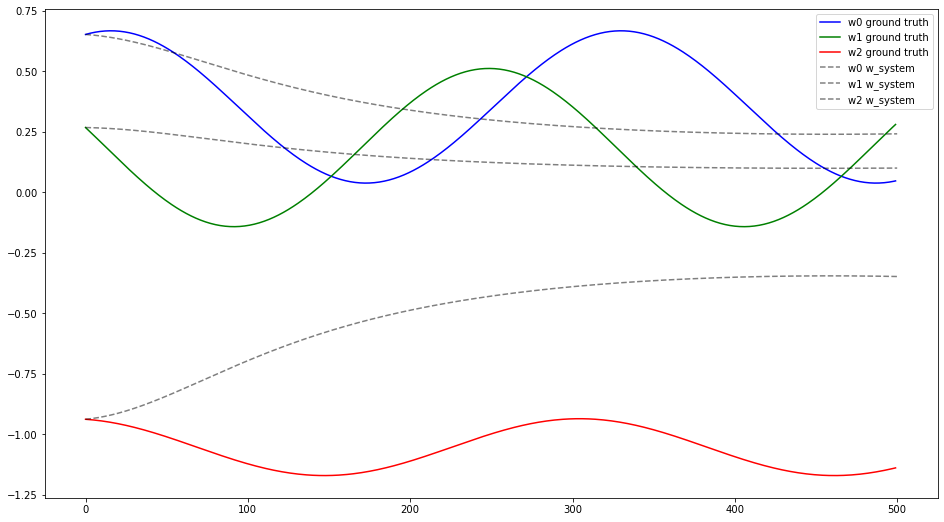

In [8]:
# Trying to use angular velocity in space-fixed coordinates to evolve the system
prefix = 'hexagons/trajectories/single/'
file_name = prefix+'NVE-temp-2.25_K-0.018140589569161_r-0_s-5'


device = 'cpu'

reader = Reader(file_name)
# log_labels, log_lines = reader.read_simulation_log()
traj_labels, traj_lines = reader.read_reduced_traj(save=True)
# orig_labels, orig_lines = reader.read_original_traj(save=True)


centre_of_masses, quaternions, velocities, ang_velocities, ang_momenta, inertia = get_data(file_name)
inertia = process_inertia(inertia)
trajectory = process_data(centre_of_masses, quaternions, velocities, ang_momenta, inertia)

initial_timestep = 10
angvel = ang_velocities.to_numpy()[:, 1:]
quat = trajectory[3][0, :, 0, :]

initial_quat = quat[initial_timestep, :].clone()
J = np.identity(3) #* inertia[0].numpy()
J_inv = np.linalg.inv(J)
q_i = initial_quat.numpy()
w_i = angvel[initial_timestep, :]

log_freq = reader.log_frequency
time_step = reader.timestep
dt = time_step * log_freq
timesteps = 500

def vecquat_multiply(a, b):
    a = quaternion.from_vector_part(a)
    b = quaternion.from_float_array(b)
    c = a * b
    return quaternion.as_float_array(c)

def quatquat_multiply(a, b):
    a = quaternion.from_float_array(a)
    b = quaternion.from_float_array(b)
    c = a * b
    return quaternion.as_float_array(c)

def omega(q, w):
    w = body_to_lab(q, w)
    diffqs = 0.5 * vecquat_multiply(w, q)

    def G(q):
        return np.array([[-q[1], q[0], q[3], -q[2]], [-q[2], -q[3], q[0], q[1]], [-q[3], q[2], -q[1], q[0]]]).squeeze()

    return 2 * G(q) @ G(diffqs).T

def J_inv_system(J, q):
    q = quaternion.from_float_array(q)
    R = quaternion.as_rotation_matrix(q)
    R_inv = R.T
    J_new = np.matmul(np.matmul(R, J), R_inv)
    return np.linalg.inv(J)

def diffangvel(q, w):
    diffq = 0.5 * vecquat_multiply(w, q)
    
    def G(q):
        return np.array([[-q[1], q[0], q[3], -q[2]], [-q[2], -q[3], q[0], q[1]], [-q[3], q[2], -q[1], q[0]]]).squeeze()
    wbody = lab_to_body(q, w)
    lbody = J @ wbody
    # TODO: change G.T @ lbody to quatvec multiplication
    g = 2 * G(q).T @ lbody
    
    return 0.5 * J_inv_system(J, q) @ quatquat_multiply(diffq, g)[1:]

def lab_to_body(q, a):
    a = quaternion.from_vector_part(a)
    q = quaternion.from_float_array(q)
    a_ = q * a * q.conj()
    return quaternion.as_vector_part(a_)

def body_to_lab(q, a):
    a = quaternion.from_vector_part(a)
    q = quaternion.from_float_array(q)
    a_ = q.conj() * a * q
    return quaternion.as_vector_part(a_)


def velverlet_step(q, w, dt, diffw):
    # dqdt = 0.5 * w_system * q
    q_half = q + 0.5 * 0.5 * dt * vecquat_multiply(w, q)
    q_half = q_half / np.linalg.norm(q_half)
    
    # testing out that verlet is correct
    # w_full = w + diffw #dt * diffangvel(q_half, w)
    w_full = w + dt * diffangvel(q_half, w)
    q_full = q_half + 0.5 * 0.5 * dt * vecquat_multiply(w_full, q)
    q_full = q_full / np.linalg.norm(q_full)
    return w_full, q_full

q = q_i
w = w_i
traj_q = [q.squeeze()]
traj_w = [w.squeeze()]

assert len(q) == 4, 'q must have 4 coords'

for i in range(timesteps):
    diffw = angvel[initial_timestep+i+1, :] - angvel[initial_timestep+i, :]
    w, q = velverlet_step(q, w, dt, diffw)
    traj_q.append(q.squeeze())
    traj_w.append(w.squeeze())

    if i % 100 == 0:
        print(i)

traj_q = np.stack(traj_q)
traj_w = np.stack(traj_w)

plot = 'angvel'

if plot == 'quat':

    plt.plot(quat[initial_timestep:initial_timestep+timesteps, 0], 'b', label='q0 ground truth')
    plt.plot(quat[initial_timestep:initial_timestep+timesteps, 1], 'g', label='q1 ground truth')
    plt.plot(quat[initial_timestep:initial_timestep+timesteps, 2], 'r', label='q2 ground truth')
    plt.plot(quat[initial_timestep:initial_timestep+timesteps, 3], 'c', label='q3 ground truth')

    plt.plot(traj_q[:, 0], 'k--', alpha=0.5, label='q0 w_system')
    plt.plot(traj_q[:, 1], 'k--', alpha=0.5, label='q1 w_system')
    plt.plot(traj_q[:, 2], 'k--', alpha=0.5, label='q2 w_system')
    plt.plot(traj_q[:, 3], 'k--', alpha=0.5, label='q3 w_system')

elif plot == 'angvel':
    plt.plot(angvel[initial_timestep:initial_timestep+timesteps, 0], 'b', label='w0 ground truth')
    plt.plot(angvel[initial_timestep:initial_timestep+timesteps, 1], 'g', label='w1 ground truth')
    plt.plot(angvel[initial_timestep:initial_timestep+timesteps, 2], 'r', label='w2 ground truth')

    plt.plot(traj_w[:, 0], 'k--', alpha=0.5, label='w0 w_system')
    plt.plot(traj_w[:, 1], 'k--', alpha=0.5, label='w1 w_system')
    plt.plot(traj_w[:, 2], 'k--', alpha=0.5, label='w2 w_system')
   


plt.legend()
plt.savefig('hexagon_quat_traj.png')
plt.show()

In [14]:
# w = quaternion.from_vector_part([0.33495367, 0.51216149, -1.00079899])
w = quaternion.from_vector_part([0.530495367, 0.304216149, -1.00079899])
q = quaternion.from_float_array([-0.98289545, 0.10174952, 0.12170476, -0.09354956])
q_new = quaternion.from_float_array((-0.9906947, 0.08145383, 0.09988783, -0.04372304))
# q_new = quaternion.from_float_array((-2, -0.124, -0.25, 1.2)).normalized()


print('w system', w)
print('w body', q * w * q.conj())
print('q', q)
print('w', w)
print('q.conj()', q.conj())
w = q * w * q.conj()
print('w system', q_new.conj() * w * q_new)
w = q_new.conj() * w * q_new
print('final', quaternion.as_vector_part(w))

print('====')
print(q)
print(q_new)
print('one?', q_new.conj() * q)
print('one?', q.conj() * q_new)
print('one?', q * q.conj())


print('===')

first = q_new.conj() * q
last = q.conj() * q_new

w = quaternion.from_vector_part([0.334954, 0.512162, -1.0008])
print(first * w * last)

print(quaternion.as_euler_angles(first))

w system quaternion(0, 0.530495367, 0.304216149, -1.00079899)
w body quaternion(0, 0.715573813517164, 0.225899491279209, -0.901385019426329)
q quaternion(-0.98289545, 0.10174952, 0.12170476, -0.09354956)
w quaternion(0, 0.530495367, 0.304216149, -1.00079899)
q.conj() quaternion(-0.98289545, -0.10174952, -0.12170476, 0.09354956)
w system quaternion(-6.93889390390723e-18, 0.549825913069634, 0.325040065456073, -0.983672624005233)
final [ 0.54982591  0.32504007 -0.98367262]
====
quaternion(-0.98289545, 0.10174952, 0.12170476, -0.09354956)
quaternion(-0.9906947, 0.08145383, 0.09988783, -0.04372304)
one? quaternion(0.99828429660471, -0.0167189508432861, -0.0255641387032725, 0.0499540961282748)
one? quaternion(0.99828429660471, 0.0167189508432861, 0.0255641387032725, -0.0499540961282748)
one? quaternion(0.999999999233784, 0, -1.73472347597681e-18, -1.38777878078145e-17)
===
quaternion(2.77555756156289e-17, 0.334953999693594, 0.512161995124594, -1.00079999857222)
[ 2.61240875  0.06110119 -2.51

6.399933399209301e-09
6.399933399209301e-09


In [31]:
prefix = 'hexagons/trajectories/test/'
file_name = prefix+'NVE-temp-2.25_K-0.018140589569161_r-0_s-5'
device = 'cpu'

reader = Reader(file_name)
# log_labels, log_lines = reader.read_simulation_log()
traj_labels, traj_lines = reader.read_reduced_traj(save=True)
orig_labels, orig_lines = reader.read_original_traj(save=True)


centre_of_masses, quaternions, velocities, ang_velocities, ang_momenta, inertia = get_data(file_name)
inertia = process_inertia(inertia)
trajectory = process_data(centre_of_masses, quaternions, velocities, ang_momenta, inertia)
print(quaternions)

Found timestep: 1e-05, n of run steps: 10000, and dump log freq: 100
     timestep  c_q_1[1]  c_q_1[2]  c_q_1[3]  c_q_1[4]  c_q_2[1]  c_q_2[2]  \
0         0.0  0.000000  0.000000  0.000000  1.000000       0.0       0.0   
1       100.0  0.000899  0.000473  0.000572  0.999999       0.0       0.0   
2       200.0  0.001798  0.000946  0.001145  0.999997       0.0       0.0   
3       300.0  0.002696  0.001421  0.001717  0.999994       0.0       0.0   
4       400.0  0.003594  0.001897  0.002290  0.999989       0.0       0.0   
..        ...       ...       ...       ...       ...       ...       ...   
96     9600.0  0.083441  0.049822  0.055009  0.993745       0.0       0.0   
97     9700.0  0.084275  0.050386  0.055583  0.993614       0.0       0.0   
98     9800.0  0.085108  0.050950  0.056158  0.993482       0.0       0.0   
99     9900.0  0.085941  0.051515  0.056732  0.993349       0.0       0.0   
100   10000.0  0.086772  0.052081  0.057306  0.993214       0.0       0.0   

     c

### COMPARISON BETWEEN G FROM SHIVARIMA PAPER AND QUATVEC FROM LAMMPS


In [ ]:
# COMPARISON BETWEEN G FROM SHIVARIMA PAPER AND QUATVEC FROM LAMMPS
initial_timestep = 0

ang_vel_body = trajectory[1][0, :, 0, :].numpy()
ang_vel_body_i = ang_vel_body[initial_timestep, :]

quat = trajectory[3][0, :, 0, :]
initial_quat = quat[initial_timestep, :].clone()
J = np.identity(3) #* inertia[0].numpy()
J_inv = np.linalg.inv(J)
w_i = ang_vel_body_i.reshape(-1, 1)
q_i = initial_quat.numpy().reshape(-1, 1)
period = 2 * np.pi / np.linalg.norm((w_i))
log_freq = reader.log_frequency
time_step = reader.timestep
dt = time_step * log_freq
timesteps = 100000

def vecquat(a, b):
    c = np.zeros((4, 1))
    c[0] = -a[0] * b[1] - a[1] * b[2] - a[2] * b[3]
    c[1] = b[0] * a[0] + a[1] * b[3] - a[2] * b[2]
    c[2] = b[0] * a[1] + a[2] * b[1] - a[0] * b[3]
    c[3] = b[0] * a[2] + a[0] * b[2] - a[1] * b[1]
    return c

def quatvec(a, b):
    c = np.zeros((4, 1))
    c[0] = -a[1] * b[0] - a[2] * b[1] - a[3] * b[2]
    c[1] = a[0] * b[0] + a[2] * b[2] - a[3] * b[1]
    c[2] = a[0] * b[1] + a[3] * b[0] - a[1] * b[2]
    c[3] = a[0] * b[2] + a[1] * b[1] - a[2] * b[0]
    return c


# TODO: WAIT BUT OUR MOMENTUM IS IN BODY FIXED COORDINATES!!!!!!!

def G(q):
    return np.array([[-q[1], q[0], q[3], -q[2]], [-q[2], -q[3], q[0], q[1]], [-q[3], q[2], -q[1], q[0]]]).squeeze() # Shivarama paper (1/2qw)
    # return np.array([[-q[1], q[0], -q[3], q[2]], [-q[2], q[3], q[0], -q[1]], [-q[3], -q[2], q[1], q[0]]]).squeeze() # LAMMPS implementation (1/2wq)

def diffquat(q, w):
    return 0.5 * G(q).T @ w 
     

def velverlet_step(q, w, dt):
    q_new = q + dt * quatvec(q, w)
    q_new = q_new / np.linalg.norm(q_new)
    return q_new

q = q_i
traj = [q.squeeze()]

assert q.shape == (4, 1), 'q must be a 4x1 array'

for i in range(timesteps):
    q = velverlet_step(q, ang_vel_body[i, :], dt)
    traj.append(q.squeeze())
traj = np.stack(traj)

plt.plot(traj[:, 0], 'b', label='q0 numerical')
plt.plot(traj[:, 1], 'g', label='q1 numerical')
plt.plot(traj[:, 2], 'r', label='q2 numerical')
plt.plot(traj[:, 3], 'c', label='q3 numerical')
plt.plot(quat[initial_timestep:initial_timestep+timesteps, 0], 'b', alpha=0.4, label='q0 traj')
plt.plot(quat[initial_timestep:initial_timestep+timesteps, 1], 'g', alpha=0.4, label='q1 traj')
plt.plot(quat[initial_timestep:initial_timestep+timesteps, 2], 'r', alpha=0.4, label='q2 traj')
plt.plot(quat[initial_timestep:initial_timestep+timesteps, 3], 'c', alpha=0.4, label='q3 traj')

##################################

def velverlet_step(q, w, dt):
    q_new = q + dt * quatvec(q, w)
    q_new = q_new / np.linalg.norm(q_new)
    return q_new

q = q_i
traj = [q.squeeze()]

assert q.shape == (4, 1), 'q must be a 4x1 array'

for i in range(timesteps):
    q = velverlet_step(q, ang_vel_body[i, :], dt)
    traj.append(q.squeeze())
traj = np.stack(traj)

plt.plot(traj[:, 0], 'b--', label='q0 numerical')
plt.plot(traj[:, 1], 'g--', label='q1 numerical')
plt.plot(traj[:, 2], 'r--', label='q2 numerical')
plt.plot(traj[:, 3], 'c--', label='q3 numerical')



# plt.plot(np.linalg.norm(ang_mom.numpy()[initial_timestep:initial_timestep+timesteps], axis=1), 'k', label='total angular momentum magnitude')
# plt.plot(ang_mom.numpy()[initial_timestep:initial_timestep+timesteps, 0], 'k', alpha=0.4, label='l1 traj')
# plt.plot(ang_mom.numpy()[initial_timestep:initial_timestep+timesteps, 1], 'k', alpha=0.6, label='l2 traj')
# plt.plot(ang_mom.numpy()[initial_timestep:initial_timestep+timesteps, 2], 'k', alpha=0.8, label='l3 traj')

# plt.plot(ang_mom.numpy()[initial_timestep:initial_timestep+timesteps, 0] / inertia[0].numpy()[0], 'k', alpha=0.4, label='w1 traj')
# plt.plot(ang_mom.numpy()[initial_timestep:initial_timestep+timesteps, 1] / inertia[0].numpy()[1], 'k', alpha=0.6, label='w2 traj')
# plt.plot(ang_mom.numpy()[initial_timestep:initial_timestep+timesteps, 2] / inertia[0].numpy()[2], 'k', alpha=0.8, label='w3 traj')

# norm_numerical = np.linalg.norm(traj, axis=1)
# plt.plot(norm_numerical, 'k', label='norm traj')
# norm_trajectory = np.linalg.norm(quat[initial_timestep:initial_timestep+timesteps, :], axis=1)
# plt.plot(norm_trajectory, 'k', alpha=0.4, label='norm traj')

# plt.plot([period / dt, period / dt],[-.5, .5], 'k--', alpha=0.3)
# plt.plot([period / dt * 2, period / dt * 2],[-.5, .5], 'k--', alpha=0.3)

plt.legend()
plt.savefig('hexagon_quat_traj.png')
plt.show()

### WHAT IS LAMMPS QUATERNION

In [24]:
prefix = 'hexagons/trajectories/periodic/'
file_name = prefix+'NVE-temp-2.25_K-0.018140589569161_r-0_s-5'

device = 'cpu'

reader = Reader(file_name)
# log_labels, log_lines = reader.read_simulation_log()
traj_labels, traj_lines = reader.read_reduced_traj(save=True)
# orig_labels, orig_lines = reader.read_original_traj(save=True)


centre_of_masses, quaternions, velocities, ang_velocities, ang_momenta, inertia = get_data(file_name)
inertia = process_inertia(inertia)
trajectory = process_data(centre_of_masses, quaternions, velocities, ang_momenta, inertia)

Found timestep: 1e-05, n of run steps: 1000000, and dump log freq: 1000


In [27]:
# quaternions from trajectory
initial_normal = np.array([0, 0, 1])
initial_normal = quaternion.from_vector_part(initial_normal)
quat = quaternion.from_float_array(trajectory[3][0, :, 0, :])

normals = quaternion.as_vector_part(quat * initial_normal * quat.conj())

counter = 0
with open(file_name+'-traj.dump', 'r') as f:
    with open('new.dump', 'w') as nf:    
        for i, line in enumerate(f):
            split = line.split()
            if len(split) < 3:
                nf.write(line)
                continue
            else:    
                if split[1] == '1':
                    if split[0] == '7':
                        line = line.split() + [str(normals[counter, 0]), str(normals[counter, 1]), str(normals[counter, 2])]
                        counter += 1
                    else:
                        line = line.split() + ['0', '0', '0']
                    nf.write(' '.join(line)+'\n')
                elif split[0] == 'ITEM:' and split[1] == 'ATOMS':
                    line = line.split() + ['mux', 'muy', 'muz']
                    nf.write(' '.join(line)+'\n')
                else:
                    nf.write(line)

In [26]:
# ang velocity from trajectory
counter = 0
with open(file_name+'-traj.dump', 'r') as f:
    with open('new.dump', 'w') as nf:    
        for i, line in enumerate(f):
            split = line.split()
            if len(split) < 3:
                nf.write(line)
                continue
            else:    
                if split[1] == '1':
                    if split[0] == '7':
                        line = line.split() + [str(angvel[counter, 0]), str(angvel[counter, 1]), str(angvel[counter, 2])]
                        counter += 1
                    else:
                        line = line.split() + ['0', '0', '0']
                    nf.write(' '.join(line)+'\n')
                elif split[0] == 'ITEM:' and split[1] == 'ATOMS':
                    line = line.split() + ['mux', 'muy', 'muz']
                    nf.write(' '.join(line)+'\n')
                else:
                    nf.write(line)

0
100
200
300
400
500
600
700
800
900


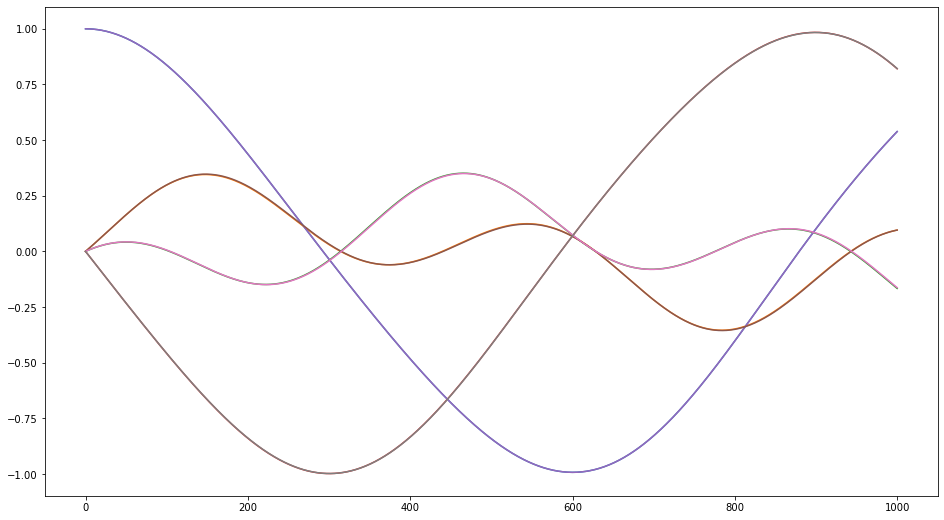

In [51]:
# our evolved quaternions
initial_timestep = 0
angvel = ang_velocities.to_numpy()[:, 1:]
quat = trajectory[3][0, :, 0, :]

initial_quat = quat[initial_timestep, :].clone()
J = np.identity(3) #* inertia[0].numpy()
J_inv = np.linalg.inv(J)
q_i = initial_quat.numpy()
log_freq = reader.log_frequency
time_step = reader.timestep
dt = time_step * log_freq
timesteps = 1000
    
def vecquat_multiply(a, b):
    a = quaternion.from_vector_part(a)
    b = quaternion.from_float_array(b)
    c = a * b
    return quaternion.as_float_array(c)


def velverlet_step(q, w, dt):
    # dqdt = 0.5 * w_system * q
    q_new = q + 0.5 * dt * vecquat_multiply(w, q)
    q_new = q_new / np.linalg.norm(q_new)
    return q_new

q = q_i
traj = [q.squeeze()]

assert len(q) == 4, 'q must have 4 coords'

for i in range(timesteps):
    q = velverlet_step(q, angvel[initial_timestep+i, :], dt)
    traj.append(q.squeeze())

    if i % 100 == 0:
        print(i)

traj = np.stack(traj)

quat = trajectory[3][0, :, 0, :]
plt.plot(quat)
plt.plot(traj)
plt.show()

initial_normal = np.array([0, 0, 1])
initial_normal = quaternion.from_vector_part(initial_normal)
quat = quaternion.from_float_array(traj)

normals = quaternion.as_vector_part(quat * initial_normal * quat.conj())

counter = 0
with open(file_name+'-traj.dump', 'r') as f:
    with open('new.dump', 'w') as nf:    
        for i, line in enumerate(f):
            split = line.split()
            if len(split) < 3:
                nf.write(line)
                continue
            else:    
                if split[1] == '1':
                    if split[0] == '7':
                        line = line.split() + [str(normals[counter, 0]), str(normals[counter, 1]), str(normals[counter, 2])]
                        counter += 1
                    else:
                        line = line.split() + ['0', '0', '0']
                    nf.write(' '.join(line)+'\n')
                elif split[0] == 'ITEM:' and split[1] == 'ATOMS':
                    line = line.split() + ['mux', 'muy', 'muz']
                    nf.write(' '.join(line)+'\n')
                else:
                    nf.write(line)

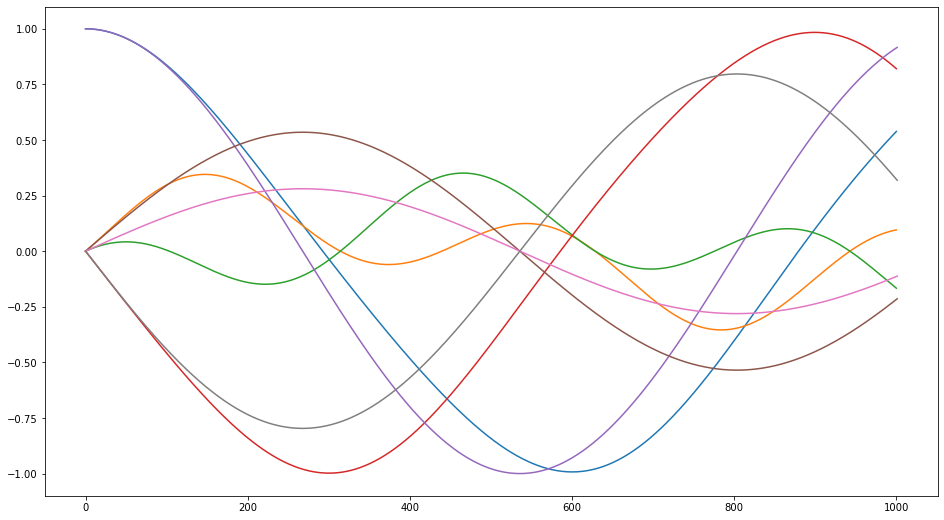

In [47]:
quat = trajectory[3][0, :, 0, :]
plt.plot(quat)
plt.plot(traj)
plt.show()

In [82]:
a = quaternion.from_vector_part([ 1.6590, -0.4562,  1.6203])
q = quaternion.quaternion(0.1929,  0.3037, -0.6874,  0.6310)
print(0.5 * a * q)
print(0.5 * q * a)

quaternion(-0.91991974, 0.57297656, -0.321372435, -0.344646395)
quaternion(-0.91991974, -0.25295546, 0.233371455, 0.657202265)


In [12]:
q1 = quaternion.quaternion(2, 3, 6, 3)
a = np.array([2, 3, 1])
print(q1.conj() * a * q1)
a = quaternion.from_vector_part(a)
print(q1.conj() * a * q1)


[quaternion(116, 0, 0, 0) quaternion(174, 0, 0, 0) quaternion(58, 0, 0, 0)]
quaternion(0, 74, 162, 124)


### Shivarama - test with angular momentum in body-fixed coords

Found timestep: 1e-05, n of run steps: 10000000, and dump log freq: 10000
Found timestep: 1e-05, n of run steps: 10000000, and dump log freq: 10000
0
100
200
300
400
500
600
700
800
900


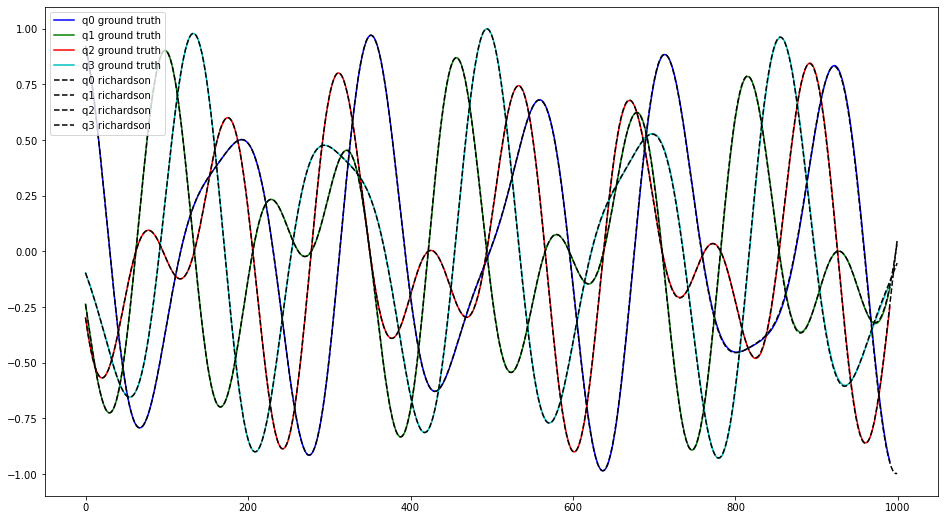

In [34]:
from data.reader import Reader
from data.trajectory import Trajectory
import quaternion
import numpy as np
import matplotlib.pyplot as plt


prefix = 'dataset/trajectories/double/'
file_name = prefix+'NVE-temp-0.45_K-0.219478737997257_r-0_s-5'

# prefix = 'hexagons/trajectories/single/'
# file_name = prefix+'NVE-temp-2.25_K-0.018140589569161_r-0_s-5'

device = 'cpu'

reader = Reader(file_name)
traj_labels, traj_lines = reader.read_reduced_traj(save=True)

traj = Trajectory(file_name, device)

centre_of_masses, quaternions, velocities, ang_velocities, ang_momenta, inertia = traj.get_data()
trajectory, inertia = traj.get_traj(reader) 

initial_timestep = 10

angmom = ang_momenta.to_numpy()[:, 1:]
angmom = angmom[:, :3]
quat = trajectory[3][0, :, 0, :].numpy()

# turn angmom into body coordinates
ang_momenta = quaternion.from_vector_part(angmom)
quaternions = quaternion.from_float_array(quat)
ang_momenta = quaternions.conj() * ang_momenta * quaternions
angmom_body = quaternion.as_vector_part(ang_momenta)

J = np.identity(3) * inertia[0].numpy()
J_inv = np.linalg.inv(J)

q_i = quat[initial_timestep, :]
lsystem_i = angmom[initial_timestep, :]
lbody_i = angmom_body[initial_timestep, :]

log_freq = reader.log_frequency
time_step = reader.timestep
dt = time_step * log_freq
timesteps = 999

def vecquat_multiply(a, b):
    a = quaternion.from_vector_part(a)
    b = quaternion.from_float_array(b)
    c = a * b
    return quaternion.as_float_array(c)

def quatvec_multiply(a, b):
    a = quaternion.from_float_array(a)
    b = quaternion.from_vector_part(b)
    c = a * b
    return quaternion.as_float_array(c)


def quatquat_multiply(a, b):
    a = quaternion.from_float_array(a)
    b = quaternion.from_float_array(b)
    c = a * b
    return quaternion.as_float_array(c)

def diffangvel(q, w):
    l = w * inertia[0].numpy()
    diffq = 0.5 * quatvec_multiply(q, w)
    
    def G(q):
        return np.array([[-q[1], q[0], q[3], -q[2]], [-q[2], -q[3], q[0], q[1]], [-q[3], q[2], -q[1], q[0]]]).squeeze()
    
    def Omega(q, diffq):
        return 2 * G(q) @ G(diffq).T

    
    # TEST OUT IDENTITY
    # v = np.array([2.0, 3.0, -1.0])
    # print('Omega @ vector', Omega(q, diffq) @ v)
    # print('w x v', np.cross(w, v))
    

    
    first_term = - Omega(q, diffq) @ l
    second_term = - 0.5 * G(q) @ np.array([0, 0, 0, 0]) # here goes the potential
    return (first_term + second_term) / inertia[0].numpy()

def velverlet_step_richardson(q, lsystem, dt, diffl):
    # 1) half update angmom
    lsystem = lsystem + 0 # as no torque applied

    # 2) get angvel from angmom
    lbody = quaternion.from_vector_part(lsystem)
    q = quaternion.from_float_array(q)
    lbody = q.conj() * lbody * q
    lbody = quaternion.as_vector_part(lbody)
    q = quaternion.as_float_array(q)

    wbody = lbody / inertia[0].numpy()

    wsystem = quaternion.from_vector_part(wbody)
    q = quaternion.from_float_array(q)
    wsystem = q * wsystem * q.conj()
    wsystem = quaternion.as_vector_part(wsystem)
    q = quaternion.as_float_array(q)

    # 3) full update q in Richardson
    q_full = q + 0.5 * dt * vecquat_multiply(wsystem, q)
    q_full = q_full / np.linalg.norm(q_full)
    
    # 4) half update q in Richardson
    q_half = q + 0.5 * 0.5 * dt * vecquat_multiply(wsystem, q)
    q_half = q_half / np.linalg.norm(q_half)

    # 5) recompute angvel from new qhalf
    lbody = quaternion.from_vector_part(lsystem)
    q = quaternion.from_float_array(q_half)
    lbody = q.conj() * lbody * q
    lbody = quaternion.as_vector_part(lbody)

    wbody = lbody / inertia[0].numpy()

    wsystem = quaternion.from_vector_part(wbody)
    q = quaternion.from_float_array(q_half)
    wsystem = q * wsystem * q.conj()
    wsystem = quaternion.as_vector_part(wsystem)

    # 6) second half update q in Richardson
    q_half = q_half + 0.5 * 0.5 * dt * vecquat_multiply(wsystem, q_half)
    q_half = q_half / np.linalg.norm(q_half)

    # 7) corrected richardson update
    q_new = 2 * q_half - q_full
    q_new = q_new / np.linalg.norm(q_new)

    # 8) final update of angmom
    lsystem = lsystem + 0 # as no torque applied
    return lsystem, q_new

def velverlet_step(q, l, dt, diffl):
    w = l / inertia[0].numpy()
    # dqdt = 0.5 * q * w_body
    q_half = q + 0.5 * 0.5 * dt * quatvec_multiply(q, w)
    q_half = q_half / np.linalg.norm(q_half)
    
    # testing out that verlet is correct
    # w_full = w + (diffl / inertia[0].numpy()) #dt * diffangvel(q_half, w)
    w_full = w + dt * diffangvel(q_half, w)
    q_full = q_half + 0.5 * 0.5 * dt * quatvec_multiply(q, w_full)
    q_full = q_full / np.linalg.norm(q_full)
    return w_full * inertia[0].numpy(), q_full


q = q_i
l = lbody_i
traj_q = [q.squeeze()]
traj_l = [l.squeeze()]


q_richardson = q_i
l_richardson = lsystem_i
traj_q_richardson = [q_richardson.squeeze()]
traj_l_richardson = [l_richardson.squeeze()]


assert len(q) == 4, 'q must have 4 coords'

for i in range(timesteps):
    diffl = 0#angmom[initial_timestep+i+1, :] - angmom[initial_timestep+i, :]
    l_richardson, q_richardson = velverlet_step_richardson(q_richardson, l_richardson, dt, diffl)
    l, q = velverlet_step(q, l, dt, diffl)
    
    traj_q.append(q.squeeze())
    traj_l.append(l.squeeze())
    
    traj_q_richardson.append(q_richardson.squeeze())
    traj_l_richardson.append(l_richardson.squeeze())

    if i % 100 == 0:
        print(i)

traj_q = np.stack(traj_q)
traj_l = np.stack(traj_l)

traj_q_richardson = np.stack(traj_q_richardson)
traj_l_richardson = np.stack(traj_l_richardson)


plt.figure(figsize=(16, 9))
plt.plot(quat[initial_timestep:initial_timestep+timesteps, 0], 'b', label='q0 ground truth')
plt.plot(quat[initial_timestep:initial_timestep+timesteps, 1], 'g', label='q1 ground truth')
plt.plot(quat[initial_timestep:initial_timestep+timesteps, 2], 'r', label='q2 ground truth')
plt.plot(quat[initial_timestep:initial_timestep+timesteps, 3], 'c', label='q3 ground truth')

# plt.plot(traj_q[:, 0], 'k--', alpha=1, label='q0 velverlet')
# plt.plot(traj_q[:, 1], 'k--', alpha=1, label='q1 velverlet')
# plt.plot(traj_q[:, 2], 'k--', alpha=1, label='q2 velverlet')
# plt.plot(traj_q[:, 3], 'k--', alpha=1, label='q3 velverlet')

plt.plot(traj_q_richardson[:, 0], 'k--', alpha=1, label='q0 richardson ')
plt.plot(traj_q_richardson[:, 1], 'k--', alpha=1, label='q1 richardson')
plt.plot(traj_q_richardson[:, 2], 'k--', alpha=1, label='q2 richardson')
plt.plot(traj_q_richardson[:, 3], 'k--', alpha=1, label='q3 richardson')


plt.legend()
plt.savefig('velverlet_v_richardson.png', dpi=300)
plt.show()

# plt.plot(angmom[initial_timestep:initial_timestep+timesteps, 0], 'b', label='l0 ground truth')
# plt.plot(angmom[initial_timestep:initial_timestep+timesteps, 1], 'g', label='l1 ground truth')
# plt.plot(angmom[initial_timestep:initial_timestep+timesteps, 2], 'r', label='l2 ground truth')

# plt.plot(traj_l[:, 0], 'k--', alpha=0.5, label='l0 body velverlet')
# plt.plot(traj_l[:, 1], 'k--', alpha=0.5, label='l1 body velverlet')
# plt.plot(traj_l[:, 2], 'k--', alpha=0.5, label='l2 body velverlet')

# plt.plot(traj_l_richardson[:, 0], 'k-', alpha=0.3, label='l0 body richardson')
# plt.plot(traj_l_richardson[:, 1], 'k-', alpha=0.3, label='l1 body richardson')
# plt.plot(traj_l_richardson[:, 2], 'k-', alpha=0.3, label='l2 body richardson')


# plt.legend()
# # plt.savefig('velverlet_v_richardson.png', dpi=300)
# plt.show()

In [ ]:

def velverlet_step_richardson(q, l, dt, diffl):

    w = l / inertia[0].numpy()

    # initially, update angvel to 1/2 step
    w_half = w + 0.5 * dt * diffangvel(q, w)

    # full richardson update
    # dqdt = 0.5 * q * w_body
    q_full = q + 0.5 * dt * quatvec_multiply(q, w_half)
    q_full = q_full / np.linalg.norm(q_full)
    
    # 1st half update
    q_half = q + 0.5 * 0.5 * dt * quatvec_multiply(q, w_half)
    q_half = q_half / np.linalg.norm(q_half)

    # TODO: MISSING THIS RECOMUPTATION OF ANGULAR MOMENTA?
    q_r = quaternion.from_float_array(q) / quaternion.from_float_array(q_half)
    # q_r = quaternion.from_float_array(q) * quaternion.from_float_array(q_half).conj()
    q_r = quaternion.as_float_array(q_r)
    q_r = q_r / np.linalg.norm(q_r)
    q_r = quaternion.from_float_array(q_r)

    print('old w_half', w_half)
    w_half = quaternion.from_vector_part(w_half)
    w_half = q_r.conj() * w_half * q_r
    w_half = quaternion.as_vector_part(w_half)
    print('new w_half', w_half)

    # 2nd half update
    q_half = q_half + 0.5 * 0.5 * dt * quatvec_multiply(q_half, w_half)
    q_half = q_half / np.linalg.norm(q_half)

    # corrected richardson update
    q_new = 2 * q_half - q_full
    q_new = q_new / np.linalg.norm(q_new)

    # final full update of w
    w_new = w_half + 0.5 * dt * diffangvel(q_new, w_half)
    return w_new * inertia[0].numpy(), q_new


In [62]:
a = [0.999795090753686, 0.0134655496048962, 0.0132277889909825, 0.00731307576031449]
a = np.array(a)
print(np.linalg.norm(a))

0.9999999999999996


In [16]:
import numpy as np
import torch
A = np.array(([-3.1225e-17,  5.3034e-01, -9.6654e-02],
        [-5.3034e-01, -2.0817e-17,  2.9543e-01],
        [ 9.6654e-02, -2.9543e-01, -2.7756e-17])).astype('float64')
b = np.array([-0.2954, -0.0967, -0.5303]).astype('float64')
print(A.shape)
print(b.shape)
print(A @ b)

print(A)
print(b)

A = torch.from_numpy(A).type(torch.float64)
b = torch.from_numpy(b).type(torch.float64)
print(A @ b)


b = np.array([-1.68518832, -1.65516638, -1.13124087])
A = np.array(([ 0.00000000e+00 , 1.88540145e-01, -5.51722128e-01], [-1.88540145e-01 , 2.77555756e-17 , 5.61729441e-01],  [ 5.51722128e-01, -5.61729441e-01 , 2.77555756e-17]))
print(A.shape)
print(A @ b / inertia[0].numpy())
# [-1.04021770e-01  1.05908550e-01 -1.32706768e-17]

print(np.dot(A, b) / inertia[0].numpy())

(3, 3)
(3,)
[-2.82618e-05 -4.09300e-06  1.64894e-05]
[[-3.1225e-17  5.3034e-01 -9.6654e-02]
 [-5.3034e-01 -2.0817e-17  2.9543e-01]
 [ 9.6654e-02 -2.9543e-01 -2.7756e-17]]
[-0.2954 -0.0967 -0.5303]
tensor([-2.8262e-05, -4.0930e-06,  1.6489e-05], dtype=torch.float64)
(3, 3)
[ 1.04021770e-01 -1.05908550e-01 -9.86252243e-11]
[ 1.04021770e-01 -1.05908550e-01 -9.86252243e-11]


### Angular Momentum is also in space-fixed coordinates

Found timestep: 1e-05, n of run steps: 4000000, and dump log freq: 1000


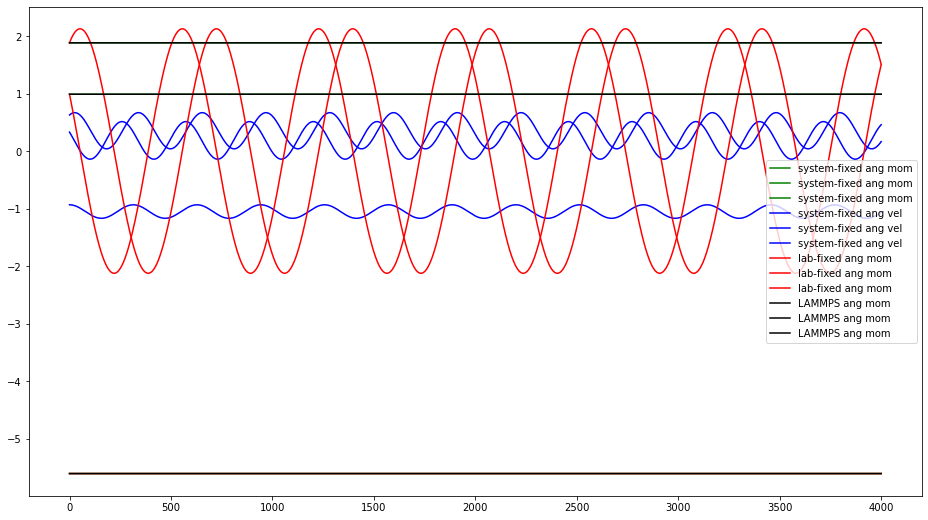

In [7]:
prefix = 'hexagons/trajectories/single/'
file_name = prefix+'NVE-temp-2.25_K-0.018140589569161_r-0_s-5'

device = 'cpu'

reader = Reader(file_name)
traj_labels, traj_lines = reader.read_reduced_traj(save=True)


centre_of_masses, quaternions, velocities, ang_velocities, ang_momenta, inertia = get_data(file_name)
inertia = process_inertia(inertia)
trajectory = process_data(centre_of_masses, quaternions, velocities, ang_momenta, inertia)

initial_timestep = 10
angvel = ang_velocities.to_numpy()[:, 1:]
quat = trajectory[3][0, :, 0, :]

# 1) Rotate J's to system fixed
J = np.identity(3) * inertia.numpy()
R = quaternion.as_rotation_matrix(quaternion.from_float_array(quat))
R_inv = R.transpose(0, 2, 1)
J_new = np.matmul(np.matmul(R, J), R_inv)

# 2) system-fixed ang vel to ang mom based on rotated J
ang_momenta = np.matmul(angvel.reshape(-1, 1, 3), J_new).squeeze()
plt.plot(ang_momenta, 'g', label='system-fixed ang mom')


# 3) system coords to body coords
ang_momenta = quaternion.from_vector_part(ang_momenta)
quaternions = quaternion.from_float_array(quat)
ang_momenta = quaternions.conj() * ang_momenta * quaternions
ang_momenta = quaternion.as_vector_part(ang_momenta)
quaternions = quaternion.as_float_array(quaternions)

plt.plot(angvel, 'b', label='system-fixed ang vel')
plt.plot(ang_momenta, 'r', label='lab-fixed ang mom')


# get angular momenta from LAMMPS
centre_of_masses, quaternions, velocities, ang_velocities, ang_momenta, inertia = get_data(file_name)
ang_momenta = ang_momenta.to_numpy()[:, 1:]
plt.plot(ang_momenta, 'k', label='LAMMPS ang mom')


plt.legend()
plt.savefig('momenta_type.png')
plt.show()



### Testing working solution with PyTorch

In [78]:
import torch

def get_batch_mod(traj, batch_size, batch_length, dt):
    """
    Get a batch of data from a trajectory.
        
    Args:
        traj (tuple): torch tensors containing the data (velocities, angular velocities, centre of masses, quaternions)
        batch_size (int): number of trajectories in the batch
        batch_length (int): length of each trajectory in the batch
        dt (float): time step
    
    Returns:
        batch_t (torch.Tensor): time steps for the batch
        pos_init (torch.Tensor): initial positions for the batch
        batch_trajs (tuple): batch of torch tensors containing the data (velocities, angular velocities, centre of masses, quaternions - in the form (nparticles, batch_size, batch_length, dim))
    """
    nparticles = trajectory[0].shape[2]
    vel_dim = trajectory[0].size()[3]
    angvel_dim = trajectory[1].size()[3]
    com_dim = trajectory[2].size()[3]
    quat_dim = trajectory[3].size()[3]

    assert vel_dim == 3, 'velocity dimension must be 3'
    assert angvel_dim == 3, 'angular velocity dimension must be 3'
    assert com_dim == 3, 'centre of mass dimension must be 3'
    assert quat_dim == 4, 'quaternion dimension must be 4'

    sampled_is = torch.randint(traj[0].shape[0],size = (batch_size,)).to(device)
    sampled_js = torch.randint(traj[0].shape[1]-batch_length,size = (batch_size,)).to(device)
    initial_time = sampled_js*dt

    batch_t = torch.linspace(0.0,dt*(batch_length-1),batch_length).to(device)
    
    vels = torch.swapaxes(traj[0][sampled_is,sampled_js,:,:], 0, 1)
    ang_vels = torch.swapaxes(traj[1][sampled_is,sampled_js,:,:], 0, 1)
    coms = torch.swapaxes(traj[2][sampled_is,sampled_js,:,:], 0, 1)
    quats = torch.swapaxes(traj[3][sampled_is,sampled_js,:,:], 0, 1)
    
    pos_init = (vels, ang_vels, coms, quats)

    sampled_vels = []
    sampled_ang_vels = []
    sampled_coms = []
    sampled_quats = []
    for i in range(batch_size):
        vels = torch.swapaxes(traj[0][sampled_is[i],sampled_js[i]:sampled_js[i]+batch_length,:], 0, 1)
        ang_vels = torch.swapaxes(traj[1][sampled_is[i],sampled_js[i]:sampled_js[i]+batch_length,:], 0, 1)
        coms = torch.swapaxes(traj[2][sampled_is[i],sampled_js[i]:sampled_js[i]+batch_length,:], 0, 1)
        quats = torch.swapaxes(traj[3][sampled_is[i],sampled_js[i]:sampled_js[i]+batch_length,:], 0, 1)
        
        sampled_vels.append(vels)
        sampled_ang_vels.append(ang_vels)
        sampled_coms.append(coms)
        sampled_quats.append(quats)
        
    sampled_vels = torch.stack(sampled_vels, dim=1).type(torch.float64)
    sampled_ang_vels = torch.stack(sampled_ang_vels, dim=1).type(torch.float64)
    sampled_coms = torch.stack(sampled_coms, dim=1).type(torch.float64)
    sampled_quats = torch.stack(sampled_quats, dim=1).type(torch.float64)
    batch_trajs = (sampled_vels, sampled_ang_vels, sampled_coms, sampled_quats)

    return batch_t, pos_init, batch_trajs


def get_data(file_name):
    # train_split = 0.9
    # test_split = 1 - train_split
    df = pd.read_csv(file_name+'-reduced_traj.csv')
    # HACK: do this based on the column names, not explicitly
    com = ['c_com_1[1]', 'c_com_1[2]', 'c_com_1[3]', 'c_com_2[1]', 'c_com_2[2]', 'c_com_2[3]']
    q = ['c_q_1[1]', 'c_q_1[2]', 'c_q_1[3]', 'c_q_1[4]', 'c_q_2[1]', 'c_q_2[2]', 'c_q_2[3]', 'c_q_2[4]']
    vel = ['c_vel_1[1]', 'c_vel_1[2]', 'c_vel_1[3]', 'c_vel_2[1]', 'c_vel_2[2]', 'c_vel_2[3]'] 
    av = ['c_av_1[1]', 'c_av_1[2]', 'c_av_1[3]', 'c_av_2[1]', 'c_av_2[2]', 'c_av_2[3]']
    am = ['c_am_1[1]', 'c_am_1[2]', 'c_am_1[3]', 'c_am_2[1]', 'c_am_2[2]', 'c_am_2[3]']
    inertia = ['c_i_1[1]', 'c_i_1[2]', 'c_i_1[3]', 'c_i_2[1]', 'c_i_2[2]', 'c_i_2[3]']
    
    centre_of_masses = df.loc[:, ['timestep', *com]]
    quaternions = df.loc[:, ['timestep', *q]]
    velocities = df.loc[:, ['timestep', *vel]]
    ang_velocities = df.loc[:, ['timestep', *av]]
    ang_momenta = df.loc[:, ['timestep', *am]]
    # inertia = df.loc[0, ['timestep', *inertia]]
    inertia = df.loc[:, ['timestep', *inertia]]
    # TODO: use DataLoaders?
    
    # trajs = np.load('data/trajectories/diatomic_spring_narrow.npy')
    # split_index = int(trajs.shape[0] * train_split)

    # np.random.shuffle(trajs)
    # training_trajs = torch.Tensor(trajs[:split_index, :, :]).to(device)
    # testing_trajs = torch.Tensor(trajs[split_index:, :, :]).to(device)
    
    return centre_of_masses, quaternions, velocities, ang_velocities, ang_momenta, inertia

def process_inertia(inertia):
    assert np.all(inertia.std().iloc[1:].to_numpy() == 0), 'inertia is not constant'
    inertia = inertia.iloc[0, 1:].to_numpy().reshape(2, 3)
    return torch.from_numpy(inertia).to(device)



def process_data(centre_of_masses, quaternions, velocities, ang_velocities, inertia):
    # TODO: swap -1 and nparticles in view to avoid swapping axes later on
    # HACK: send a single trajectory
    ntraj = 1

    # HACK: pair potential
    nparticles = 2
    vel_dim = 3
    angvel_dim = 3
    com_dim = 3
    quat_dim = 4

    # Get centre of masses
    com1 = centre_of_masses.loc[:, ['c_com_1[1]', 'c_com_1[2]', 'c_com_1[3]']].to_numpy()
    com2 = centre_of_masses.loc[:, ['c_com_2[1]', 'c_com_2[2]', 'c_com_2[3]']].to_numpy()
    # separation = np.linalg.norm(com1-com2, axis=1).reshape(-1, 1)
    coms = torch.from_numpy(np.hstack((com1, com2))).to(device).view(ntraj, -1, nparticles, com_dim)
    
    # Get quaternion rotations (swap axes to put real part first)
    quat1 = quaternions.loc[:, ['c_q_1[4]', 'c_q_1[1]', 'c_q_1[2]', 'c_q_1[3]']].to_numpy()
    quat2 = quaternions.loc[:, ['c_q_2[4]', 'c_q_2[1]', 'c_q_2[2]', 'c_q_2[3]']].to_numpy()
    quats = torch.from_numpy(np.hstack((quat1, quat2))).to(device).view(ntraj, -1, nparticles, quat_dim)
    
    # Get translation velocities
    vel1 = velocities.loc[:, ['c_vel_1[1]', 'c_vel_1[2]', 'c_vel_1[3]']].to_numpy()
    vel2 = velocities.loc[:, ['c_vel_2[1]', 'c_vel_2[2]', 'c_vel_2[3]']].to_numpy() 
    # hexagon_mass = 7.0
    # mom = torch.from_numpy(np.hstack((vel1 * hexagon_mass, vel2 * hexagon_mass))).to(device).view(ntraj, -1, nparticles, vel_dim)
    vel = torch.from_numpy(np.hstack((vel1, vel2))).to(device).view(ntraj, -1, nparticles, vel_dim)

    # Get angular velocities
    ang_vel_1 = ang_velocities.loc[:, ['c_av_1[1]', 'c_av_1[2]', 'c_av_1[3]']].to_numpy()
    ang_vel_2 = ang_velocities.loc[:, ['c_av_2[1]', 'c_av_2[2]', 'c_av_2[3]']].to_numpy()
    # Convert system to body coords
    # TODO: we could do this when writing to CSV to speed up training
    quat1 = quaternion.from_float_array(quat1)
    quat2 = quaternion.from_float_array(quat2)
    ang_vel_1 = quaternion.from_vector_part(ang_vel_1)
    ang_vel_2 = quaternion.from_vector_part(ang_vel_2)
    ang_vel_1 = quat1.conj() * ang_vel_1 * quat1
    ang_vel_2 = quat2.conj() * ang_vel_2 * quat2
    ang_vel_1 = quaternion.as_vector_part(ang_vel_1)
    ang_vel_2 = quaternion.as_vector_part(ang_vel_2)
    ang_vel = torch.from_numpy(np.stack((ang_vel_1, ang_vel_2))).to(device).view(ntraj, -1, nparticles, angvel_dim)
    return (vel, ang_vel, coms, quats)


torch.Size([2, 3, 300, 4])


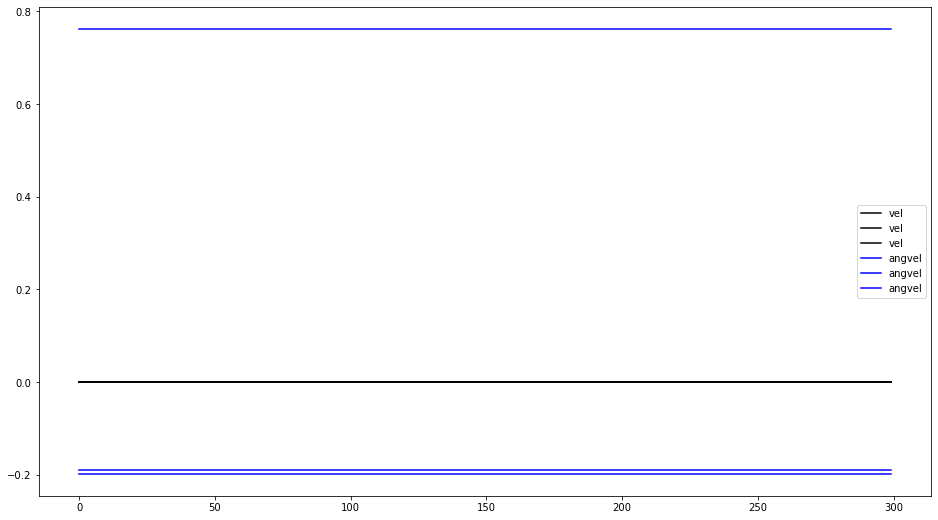

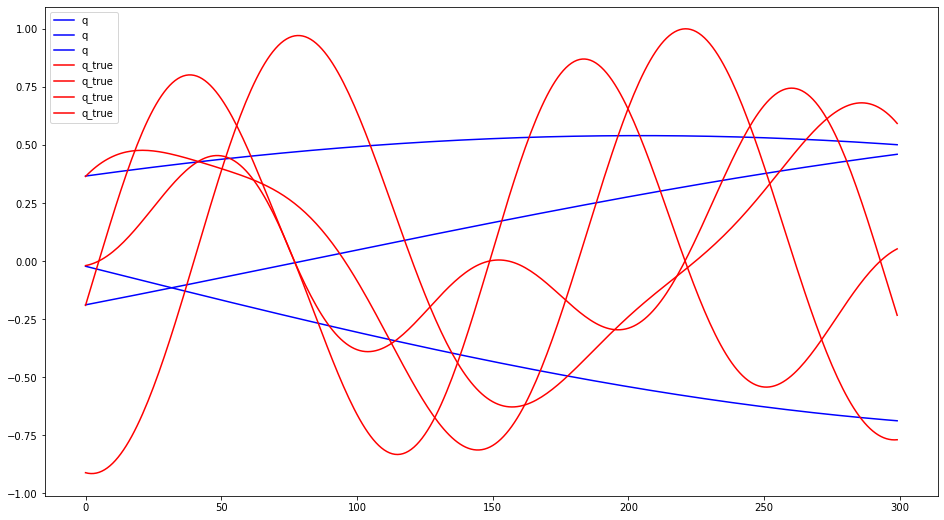

In [91]:
from diffmd.utils import quatvec 
nparticles = 2 # trajectory[2].shape[0] ? 
batch_size = 3
batch_length = 300
log_freq = reader.log_frequency
time_step = reader.timestep
dt = time_step * log_freq

prefix = 'hexagons/trajectories/double/'
file_name = prefix+'NVE-temp-0.45_K-0.219478737997257_r-0_s-5'

centre_of_masses, quaternions, velocities, ang_velocities, ang_momenta, inertia = get_data(file_name)

inertia = process_inertia(inertia)
trajectory = process_data(centre_of_masses, quaternions, velocities, ang_velocities, inertia)

batch_t, batch_y0, batch_y = get_batch_mod(trajectory, batch_size, batch_length, dt)   
print(batch_y[3].shape)

def dqdt(q, w):
    return 0.5 * quatvec(q, w)
    
def dwdt(q, w):
    return - torch.matmul(Omega(q, dqdt(q, w)), w.unsqueeze(-1)).squeeze() # - 0.5 * torch.matmul(self.G(q), grad_q.unsqueeze(-1)).squeeze() / self.inertia[:, None, :]

def G(q):
    # TODO: move this somewhere; make sure it's fast; maybe torch.stack is not ideal
    # TODO: add documentation
    G = torch.zeros(q.shape[0], q.shape[1], q.shape[2] - 1, q.shape[2]).to(q.device).type(torch.float64)
    G[:, :, 0, :] = torch.stack((-q[:, :, 1], q[:, :, 0], q[:, :, 3], -q[:, :, 2]), dim=-1)
    G[:, :, 1, :] = torch.stack((-q[:, :, 2], -q[:, :, 3], q[:, :, 0], q[:, :, 1]), dim=-1)
    G[:, :, 2, :] = torch.stack((-q[:, :, 3], q[:, :, 2], -q[:, :, 1], q[:, :, 0]), dim=-1)
    return G

def Omega(q, dqdt):
    # TODO: move this somewhere
    return 2 * torch.matmul(G(q), torch.transpose(G(dqdt), 2, 3))

def vel_verlet(state):
    v = state[0]
    w = state[1]
    x = state[2] # [number of bodies, number of trajectories, number of dimensions]
    q = state[3]
    

    w_step_half = 1/2 * dwdt(q, w) * dt
    q_step_full =  0.5 * quatvec(state[3], state[1] + w_step_half) * dt
    
    
    w_step_full = w_step_half + 1/2 * dwdt(q + q_step_full, w + w_step_half) * dt


    return (state[0], state[1] + w_step_full, state[2], state[3] + q_step_full)

states = []

state = batch_y0
for i in range(batch_length):
    state = vel_verlet(state)
    states.append(torch.cat(state, dim=2).cpu().detach().numpy())


states = np.stack(states)

plt.plot(states[:, 0, 0, 0:3], 'k', label='vel')
plt.plot(states[:, 0, 0, 3:6], 'b', label='angvel')
plt.legend()

plt.show()

q = batch_y[3]
plt.plot(states[:, 0, 0, 10:], 'b', label='q')
plt.plot(q[0, 0, :, :], 'r', label='q_true')
plt.legend()


plt.show()


# IMPORT TRAJECTORY

In [2]:
from data.trajectory import Trajectory

traj = Trajectory('dataset/trajectories/jakub/2.25/NVE-temp-2.25_K-17.8583270116258_r-2_s-5', 'cpu')

Found timestep: 1e-05, n of run steps: 1000000000, and dump log freq: 10000


In [3]:
print(traj.traj[0].shape)

torch.Size([1, 100001, 2, 3])


In [4]:
print(traj.traj[0][0, :100, :, :])

tensor([[[ 6.2284e-01, -2.3193e-01,  5.0184e-01],
         [ 5.4872e-01, -2.7349e-02, -5.2437e-01]],

        [[ 4.8316e-01, -1.0697e+00,  3.9916e-01],
         [ 6.8840e-01,  8.1041e-01, -4.2169e-01]],

        [[ 3.4950e-01, -1.8612e+00,  2.8577e-01],
         [ 8.2206e-01,  1.6019e+00, -3.0830e-01]],

        [[ 2.2871e-01, -2.5666e+00,  1.6846e-01],
         [ 9.4285e-01,  2.3074e+00, -1.9099e-01]],

        [[ 1.2703e-01, -3.1508e+00,  5.5258e-02],
         [ 1.0445e+00,  2.8915e+00, -7.7789e-02]],

        [[ 4.9806e-02, -3.5853e+00, -4.4388e-02],
         [ 1.1218e+00,  3.3260e+00,  2.1857e-02]],

        [[ 1.2771e-03, -3.8506e+00, -1.1857e-01],
         [ 1.1703e+00,  3.5914e+00,  9.6043e-02]],

        [[-1.1943e-01, -3.8101e+00,  4.3945e-02],
         [ 1.2910e+00,  3.5508e+00, -6.6477e-02]],

        [[-7.3564e-01, -3.6932e-01,  1.0049e+00],
         [ 1.9072e+00,  1.1004e-01, -1.0274e+00]],

        [[-7.3590e-01, -3.2302e-01,  1.0368e+00],
         [ 1.9075e+00,  6.3744e-

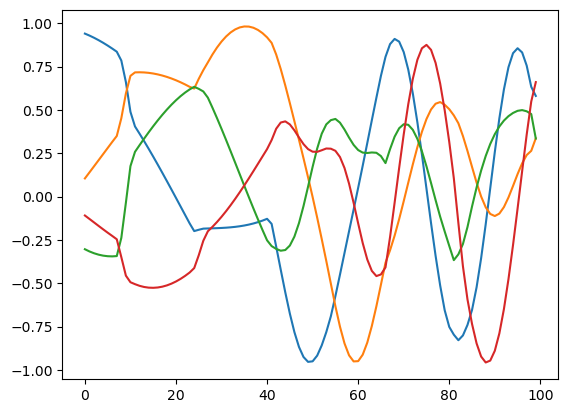

In [8]:
import matplotlib.pyplot as plt

plt.plot(traj.traj[3][0, :100, 0, :], '-')
plt.show()

In [ ]:
import torch
import numpy as np

a = torch.rand(3, 4, 5)
print(a)

a = a.to('cuda')

print(a)


tensor([[[0.3494, 0.7028, 0.0113, 0.7031, 0.8116],
         [0.0542, 0.7267, 0.8717, 0.6942, 0.1409],
         [0.8087, 0.6312, 0.7473, 0.5830, 0.1796],
         [0.8575, 0.5367, 0.2952, 0.6238, 0.5579]],

        [[0.2532, 0.7296, 0.5919, 0.4179, 0.7985],
         [0.1779, 0.9868, 0.0114, 0.9848, 0.5174],
         [0.5285, 0.5831, 0.1405, 0.4943, 0.2953],
         [0.4994, 0.3700, 0.3888, 0.1973, 0.4403]],

        [[0.6920, 0.3676, 0.7453, 0.8265, 0.3930],
         [0.6311, 0.3878, 0.3869, 0.5645, 0.9528],
         [0.2124, 0.3015, 0.7086, 0.4357, 0.7971],
         [0.7533, 0.6111, 0.2523, 0.8627, 0.1788]]])
tensor([[[0.3494, 0.7028, 0.0113, 0.7031, 0.8116],
         [0.0542, 0.7267, 0.8717, 0.6942, 0.1409],
         [0.8087, 0.6312, 0.7473, 0.5830, 0.1796],
         [0.8575, 0.5367, 0.2952, 0.6238, 0.5579]],

        [[0.2532, 0.7296, 0.5919, 0.4179, 0.7985],
         [0.1779, 0.9868, 0.0114, 0.9848, 0.5174],
         [0.5285, 0.5831, 0.1405, 0.4943, 0.2953],
         [0.4994, 0.370